# Contenu du notebook : 
*Contenu de 1 à 4 :* Test sur le dataset Bibliovid sur les titres, abstracts, titre+abstract et nom du journal. \\
*Contenu de 5 à 7 :* Test sur le dataset LitCovid sur les titres, abstracts et titre+abstract. 

# Contenu 1 : Titre 
Dans ce notebook nous allons tester trois modèles **RNN, CNN et RNN+CNN** pour prédire les **catégories** à partir du **titre** de l'article sur le dataset de **BiblioCovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances des modèles choisis en fonction de certains paramètres que nous avons choisi de faire varier. 

#Initialisation 

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import os 
os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

On récupère les fichiers json 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json

--2021-01-08 13:27:16--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3850131 (3.7M) [application/json]
Saving to: ‘data/bibliovid.json’

bibliovid.json      100%[===================>]   3.67M  5.07MB/s    in 0.7s    

2021-01-08 13:27:18 (5.07 MB/s) - ‘data/bibliovid.json’ saved [3850131/3850131]

FINISHED --2021-01-08 13:27:18--
Total wall clock time: 1.4s
Downloaded: 1 files, 3.7M in 0.7s (5.07 MB/s)


In [ ]:
bibliovid_file = open('data/bibliovid.json')
# litcovid_file = open('./litcovid.json')

data_bibliovid = json.loads(bibliovid_file.read())
# data_litcovid = json.loads(litcovid_file.read())

bibliovid_file.close()
# litcovid_file.close()

In [ ]:
print(data_bibliovid[0])
print(data_litcovid[0])

{'id': 769, 'slug': 'body-mass-index-and-risk-for-intubation-or-death-in-sars-cov-2-infection-a-retro', 'title': 'Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study', 'has_other_authors': True, 'impact_factor': {'id': 3, 'name': 'Intermédiaire', 'posts_count': 149, 'color': 'orange', 'order': 2}, 'goals_plain': "- Déterminer si l'obésité est associée à l'intubation ou le décès au cours de l'infection au SARS-CoV-2 - Déterminer si l'obésité est associée à l'inflammation , aux lésions cardiaques ou à la fibrinolyse dans la COVID-19", 'verbose_date': '31.07.2020', 'authors': 'Anderson MR', 'document_link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'specialties': [{'id': 4, 'name': 'Anesthésie-Réanimation'}, {'id': 12, 'name': 'Infectiologie'}], 'category': {'id': 6, 'name': 'Pronostique', 'icon': 'icon-chat'}, 'journal': {'id': 41, 'name': 'Ann Intern Med'}, 'link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'results':

#Bibliovid : prediction de categories en fonction des titres 


Quelles sont les colonnes qui nous intéressent ?

**Dans bibliovid :**

Pour la prédiction de catégories
* id 
* title
* category 
* topics 
* publication_date

Dans un premier temps : 

--> Je prédis la catégorie en fonction du titre 

In [ ]:
print(data_bibliovid[0]['title'])
print(data_bibliovid[0]['category']['id'])

Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study
6


In [ ]:
text_titles = []
labels = []

for i in range(len(data_bibliovid)):
  text_titles.append(data_bibliovid[i]['title'])
  labels.append(data_bibliovid[i]['category']['id']) #je vais chercher que l'id de la catégorie correspondante : pas besoin de normaliser 

print(text_titles[3])
print(labels[3])
#le 3 eme document appartient à la catégorie 4 

print(len(text_titles))
print(np.max(labels)) #ça me donne une idée du nombre de catégorie existante : il y'en a 8 

Hydroxychloroquine in the treatment and prophylaxis of SARS-CoV-2 infection in non- human primates
4
682
8


Je vais récupérer toutes les catégories avec leur id et le nom qui correspond 

In [ ]:
categories = {} # 7 catgéories 

for i in range(len(data_bibliovid)):
  categories[data_bibliovid[i]['category']['id']] = data_bibliovid[i]['category']['name']

print(categories)

{6: 'Pronostique', 8: 'Modélisation', 4: 'Thérapeutique', 2: 'Autres', 5: 'Epidémiologique', 3: 'Diagnostique', 7: 'Recommandations'}


## Préparation du dataset 

on  transforme les textes en entiers 

In [ ]:
# pip -version collections


Usage:   
  pip3 <command> [options]

no such option: -e


In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))

int_titles = []
for text in text_titles : 
    int_titles.append([vocab[token] for token in text.split()])

print(int_titles[10])
print(text_titles[10]) #on voit bien que des mots courants comme the, in ou COVID-19 ont des entiers plus petit parce qu'ils ont déjà du apparaitre 

[83, 31, 84, 9, 17, 85, 86, 87, 88, 89, 90]
Estimating the overdispersion in COVID-19 transmission using outbreak sizes outside China.


conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_titles[10]]) # c'est bon 

['Estimating', 'the', 'overdispersion', 'in', 'COVID-19', 'transmission', 'using', 'outbreak', 'sizes', 'outside', 'China.']


Pour décider de max_len plus tard il faut qu'on voit la longueur maximale de titre qu'on a 

(array([ 19., 103., 165., 177., 102.,  72.,  30.,  10.,   2.,   2.]),
 array([ 4. ,  6.9,  9.8, 12.7, 15.6, 18.5, 21.4, 24.3, 27.2, 30.1, 33. ]),
 <a list of 10 Patch objects>)

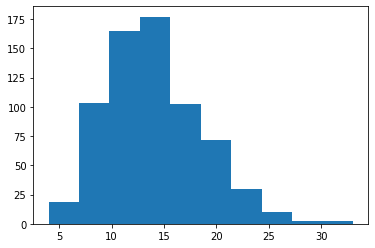

In [ ]:
len_titles = []
for i in range(len(int_titles)):
    len_titles.append(len(int_titles[i]))

plt.hist(len_titles)

Si je prends une longueur maximale de 20 ça devrait couvrir la plupart des titres qu'on a .On convertit maintenant en pytorch pour pouvoir les utiliser par la suite dans nos modèles.

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len = 20 
batch_size = 64 #128 #
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

X = torch.zeros((len(int_titles),max_len)).long()

for i, text in enumerate(int_titles):
  lenght = min(max_len,len(text))
  X[i,:lenght] = torch.LongTensor(text[:lenght])

Y = torch.tensor(labels)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([682, 20]) torch.Size([682])
tensor([41, 42, 43, 44, 10, 45, 46, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor(4, device='cuda:0')


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([477, 20])
torch.Size([205, 20])
torch.Size([477])
torch.Size([205])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

Fonction de loss et fit : je réutilise celle du tp3 

In [ ]:
from sklearn.metrics import f1_score 

def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num , f1_score(y,y_pred)

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))



##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(labels))
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        drop = self.dropout(hidden)
        return self.decision(drop.transpose(0, 1).contiguous().view(x.size(0), -1))

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(2670, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=682, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5])

tensor([[ 4.2074e-01,  4.4271e-02,  2.4130e-01,  ..., -7.4549e-01,
         -2.8701e-01,  1.0077e-01],
        [-3.4720e-02,  3.1780e-02,  4.9233e-02,  ..., -8.0957e-01,
          9.1424e-03,  8.0964e-03],
        [ 2.1033e-01, -1.8464e-01,  4.9507e-01,  ..., -8.2577e-01,
         -1.4018e-01, -3.1268e-02],
        [ 1.6009e-01,  1.5796e-01,  2.2913e-01,  ..., -6.5100e-01,
         -2.4588e-01, -1.0362e-01],
        [-2.1061e-01,  4.2055e-02,  3.3482e-01,  ..., -8.1797e-01,
         -1.1702e-01, -6.4816e-04]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_model,10)  #la loss diminue bien sur les données d'apprentissage, par contre l'accuracy pas fameux 

TypeError: ignored

Remarque : avec le double du nombre de batch size l'accuracy augmente, bien sûr pareil pour le nombre d'epochs j'ai testé avec epochs = 10 , epochs = 30 , epochs = 50.  

Il faut bien penser à chaque fois à mettre à jour le modèle sinon sur-apprentissage

##Application du CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(labels))

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))  
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

      

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (embed): Embedding(2670, 128)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=682, bias=True)
)

In [ ]:
cnn_model(X[:5])

tensor([[ 0.1770, -0.9435,  0.5976,  ..., -0.4900,  0.9410,  0.6742],
        [-0.1964, -0.0684,  0.3170,  ...,  0.1177,  1.0686, -0.2931],
        [ 0.0190,  0.0679,  0.1904,  ..., -0.0724,  1.0834,  0.5096],
        [ 0.5370,  0.1878,  0.5995,  ..., -0.5747,  0.3120,  0.7908],
        [ 0.2732,  0.0994,  0.9017,  ..., -0.1647,  0.3488,  0.5357]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(cnn_model,30) #la loss diminue aussi et l'accuracy est déjà meilleurP

0 0.09361739828401641 0.07719434412514291 0.1073170731707317
1 0.04904480700222951 0.03888743854150539 0.2048780487804878
2 0.029210481003895245 0.03692452384204399 0.25853658536585367
3 0.027321213946152532 0.03412834202370992 0.2634146341463415
4 0.02492679989812759 0.033438508685042216 0.2975609756097561
5 0.023223681020036933 0.03373353481292725 0.2780487804878049
6 0.02189448994410613 0.03285225542580209 0.3024390243902439
7 0.02000306587299211 0.03227241737086598 0.3121951219512195
8 0.019497114907270706 0.031975315256816586 0.3170731707317073
9 0.017989767172551505 0.032103465824592406 0.3170731707317073
10 0.017044039392371348 0.031596804828178594 0.32682926829268294
11 0.015782433485834853 0.0312631252335339 0.33658536585365856
12 0.015045773933018779 0.03101335444101473 0.34146341463414637
13 0.013386649155766709 0.030667695185033286 0.35121951219512193
14 0.01274919122519983 0.03059120527127894 0.36097560975609755
15 0.011898971078780712 0.030137563333278748 0.36585365853658

Pareil avec un batch size plus important l'accuracy augmente aussi mais c'est léger 

##Application du RNN+CNN 

In [ ]:
class RNN_CNN(nn.Module): #But sortie du RNN en entrée du CNN  #je declare toutes mes couches
    def __init__(self): 
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)  # (batch,seq_len,hidden_size*num_directions) 
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(labels))

    def forward(self, x): #afficher la taille au fur et à mesure - utiliser des nombers premiers pour tester 
                        #je veux un tenseur de taille (batch,seq_len,hidden_size*num_directions)
        embed = self.embed(x)
        output,hidden = self.rnn(embed)
        conv = F.relu(self.conv(output.transpose(1,2))) #.transpose(1,2))) #la couche de convolution veut cette taille en entrée(batch_size, embedding_size, sequence_length)
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

rnn_cnn_model = RNN_CNN()
rnn_cnn_model.to(device)

RNN_CNN(
  (embed): Embedding(2670, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=682, bias=True)
)

In [ ]:
rnn_cnn_model(X[:5])

tensor([[-0.2084, -0.2708, -0.1795,  ...,  0.0386,  0.1759, -0.1577],
        [-0.1225, -0.0330, -0.0725,  ...,  0.0414, -0.0717, -0.0452],
        [-0.0610, -0.2000, -0.1595,  ..., -0.1028,  0.1086,  0.1144],
        [-0.0471, -0.2116, -0.3541,  ...,  0.0186, -0.0076,  0.0251],
        [ 0.0962, -0.0032,  0.0544,  ..., -0.0423, -0.0367, -0.0843]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_cnn_model,30)

0 0.09542974336092327 0.09064865577511672 0.25853658536585367
1 0.05657785643571578 0.059076177783128694 0.25853658536585367
2 0.038457335915955355 0.041808796510463805 0.28292682926829266
3 0.03222498303939211 0.03534383483049346 0.24878048780487805
4 0.029240764911819553 0.035737563342582886 0.2780487804878049
5 0.027839207799179748 0.035966602185877355 0.2926829268292683
6 0.02520242002275255 0.034194389785208355 0.3073170731707317
7 0.024049948846269202 0.03391161604625423 0.32682926829268294
8 0.023053326696719764 0.03439329193859565 0.3121951219512195
9 0.021987798079004826 0.03357633206902481 0.32682926829268294
10 0.01935025331109325 0.033691000356906795 0.33170731707317075
11 0.016997304852403684 0.03391302853095822 0.33658536585365856
12 0.014830972413596866 0.03540196593214826 0.3463414634146341
13 0.012540957150469286 0.034942183843473106 0.37073170731707317
14 0.009978377156787448 0.03625912491868182 0.35609756097560974
15 0.008269942500306375 0.0406455290026781 0.34634146

La loss est bien meilleur mais l'accuracy pas tellement

## Comparaison des résultats 

Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour les modèles choisis : RNN, CNN et RNN + CNN. Nous faisons varier les paramètres suivant : le nombre de batch et le nombre d'epochs. On note pour chaque modèle l'accuracy et la loss obtenue (**loss/accuracy**).

*A noter que lorsqu'on fait varier le batch_size on se limite à des epochs de 10 et lorsqu'on fait varier le nombre d'epochs on fixe le nombre de batch à 64*

Remarque : En prenant le nombre d'epochs à 30 on observe déjà le phénomène de  sur-apprentissage donc on n'augmente pas le nombre d'epochs.

|Loss/Accuracy (en %) || RNN | CNN | RNN+CNN |
|----------||----------|----------|----------|
| batch_size **64**   || 29 / 33 | 1,6 / 42 | 2 / 40 |
| batch_size **128** || 1,4 / 31 | 1,1 / 33 | 1,5 / 30  |
| epochs **30** || 1,8 / 32 | 0,37 / 41 | 0,06 / 38 |


In [ ]:
from sklearn.metrics import f1_score 


# Contenu 2 : Abstract 
Dans ce notebook nous allons tester trois modèles **RNN, CNN et RNN+CNN** pour prédire les **catégories** à partir des **abstracts** de l'article sur le dataset de **Bibliocovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances des modèles choisis en fonction de certains paramètres que nous avons choisi de faire varier. 

#Initialisation 

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


In [ ]:
# import os 
# os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

On récupère les fichiers json 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json

--2021-01-05 18:38:49--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3850131 (3.7M) [application/json]
Saving to: ‘data/bibliovid.json’

bibliovid.json      100%[===================>]   3.67M  3.15MB/s    in 1.2s    

2021-01-05 18:38:51 (3.15 MB/s) - ‘data/bibliovid.json’ saved [3850131/3850131]

FINISHED --2021-01-05 18:38:51--
Total wall clock time: 2.2s
Downloaded: 1 files, 3.7M in 1.2s (3.15 MB/s)


In [ ]:
bibliovid_file = open('data/bibliovid.json')
# litcovid_file = open('./litcovid.json')

data_bibliovid = json.loads(bibliovid_file.read())
# data_litcovid = json.loads(litcovid_file.read())

bibliovid_file.close()
# litcovid_file.close()

In [ ]:
print(data_bibliovid[0])
# print(data_litcovid[0])

{'id': 769, 'slug': 'body-mass-index-and-risk-for-intubation-or-death-in-sars-cov-2-infection-a-retro', 'title': 'Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study', 'has_other_authors': True, 'impact_factor': {'id': 3, 'name': 'Intermédiaire', 'posts_count': 149, 'color': 'orange', 'order': 2}, 'goals_plain': "- Déterminer si l'obésité est associée à l'intubation ou le décès au cours de l'infection au SARS-CoV-2 - Déterminer si l'obésité est associée à l'inflammation , aux lésions cardiaques ou à la fibrinolyse dans la COVID-19", 'verbose_date': '31.07.2020', 'authors': 'Anderson MR', 'document_link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'specialties': [{'id': 4, 'name': 'Anesthésie-Réanimation'}, {'id': 12, 'name': 'Infectiologie'}], 'category': {'id': 6, 'name': 'Pronostique', 'icon': 'icon-chat'}, 'journal': {'id': 41, 'name': 'Ann Intern Med'}, 'link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'results':

#Bibliovid : prediction de categories en fonction des abstracts  

In [ ]:
print(data_bibliovid[0]['abstract'])
print(data_bibliovid[0]['category']['id'])

Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitalized. Compared with over

In [ ]:
abstracts = []
labels = []
miss_data = []

for i in range(len(data_bibliovid)):
  if 'abstract' in data_bibliovid[i] and data_bibliovid[i]['abstract'] != None : 
    abstracts.append(data_bibliovid[i]['abstract'])
    labels.append(data_bibliovid[i]['category']['id']) #je vais chercher que l'id de la catégorie correspondante : pas besoin de normaliser 
  else : 
    miss_data.append(data_bibliovid[i]['id'])

print(abstracts[3])
print(labels[3])
#le 3 eme document appartient à la catégorie 4 

print(len(abstracts))
print(len(miss_data)) # c'est la moitié quand même 

Following SARS-CoV-2 emergence in China, a specific surveillance was implemented in France. Phylogenetic analysis of sequences retrieved through this surveillance suggests that detected initial introductions, involving non-clade G viruses, did not seed local transmission. Nevertheless, identification of clade G variants subsequently circulating in the country, with the earliest from a patient who neither travelled to risk areas nor had contact with travellers, suggests that SARS-CoV-2 might have been present before the first recorded local cases.
5
377
305


In [ ]:
categories = {} # 7 catgéories 

for i in range(len(data_bibliovid)):
  categories[data_bibliovid[i]['category']['id']] = data_bibliovid[i]['category']['name']

print(categories)

{6: 'Pronostique', 8: 'Modélisation', 4: 'Thérapeutique', 2: 'Autres', 5: 'Epidémiologique', 3: 'Diagnostique', 7: 'Recommandations'}


## Préparation du dataset 

on  transforme les textes en entiers 

In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))

int_abstracts = []
for text in abstracts : 
  int_abstracts.append([vocab[token] for token in text.split()])

print(int_abstracts[10])
print(abstracts[10]) 

[465, 699, 1055, 25, 1056, 1057, 1058, 787, 1059, 7, 1060, 615, 5, 26, 27, 28, 29, 1061, 7, 1059, 531, 17, 1062, 7, 1063, 1064, 85, 1065, 5, 118, 656, 583, 191, 1066, 942, 118, 538, 339, 58, 1067, 1068, 115, 197, 1069, 1070, 1071, 17, 1072, 1073, 1074, 58, 1075, 1076, 288, 1077, 1078, 5, 1079, 57, 7, 1080, 1074, 58, 1075, 1081, 407, 1082, 650, 1083, 255, 214, 1074, 1078, 5, 118, 1084, 1000, 360, 1085, 5, 54, 55, 288, 57, 7, 1086, 1087, 102, 1071, 17, 781, 1088, 1089, 1090, 104, 20, 1091, 98, 118, 425, 451, 1092, 1093, 1094, 57, 58, 974, 7, 1095, 1096, 81, 1097, 233, 813, 85, 198, 1098, 1099, 163, 1100, 104, 948, 7, 118, 494, 495, 74, 85, 1101, 191, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 25, 1112, 58, 118, 1113, 1114, 102, 17, 1115, 538, 364, 1116, 1117, 1118, 1119, 33, 1120, 743, 1121, 1122, 1123, 7, 1110, 1111, 85, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1126, 1132, 1133, 1134, 25, 721, 1135, 7, 327, 25, 1136, 383, 384, 1137, 1138, 884, 7, 881, 1139, 7, 11

conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_abstracts[10]]) # c'est bon 

['In', 'our', 'institute', 'in', 'Marseille,', 'France,', 'we', 'initiated', 'early', 'and', 'massive', 'screening', 'for', 'coronavirus', 'disease', '2019', '(COVID-19).', 'Hospitalization', 'and', 'early', 'treatment', 'with', 'hydroxychloroquine', 'and', 'azithromycin', '(HCQ-AZ)', 'was', 'proposed', 'for', 'the', 'positive', 'cases.', 'We', 'retrospectively', 'report', 'the', 'clinical', 'management', 'of', '3,737', 'screened', 'patients,', 'including', '3,119', '(83.5%)', 'treated', 'with', 'HCQ-AZ', '(200', 'mg', 'of', 'oral', 'HCQ,', 'three', 'times', 'daily', 'for', 'ten', 'days', 'and', '500', 'mg', 'of', 'oral', 'AZ', 'on', 'day', '1', 'followed', 'by', '250', 'mg', 'daily', 'for', 'the', 'next', 'four', 'days,', 'respectively)', 'for', 'at', 'least', 'three', 'days', 'and', '618', '(16.5%)', 'patients', 'treated', 'with', 'other', 'regimen', '("others").', 'Outcomes', 'were', 'death,', 'transfer', 'to', 'the', 'intensive', 'care', 'unit', '(ICU),', '≥10', 'days', 'of', 'hosp

(array([ 48.,  98., 142.,  61.,  21.,   5.,   1.,   0.,   0.,   1.]),
 array([  0. ,  97.8, 195.6, 293.4, 391.2, 489. , 586.8, 684.6, 782.4,
        880.2, 978. ]),
 <a list of 10 Patch objects>)

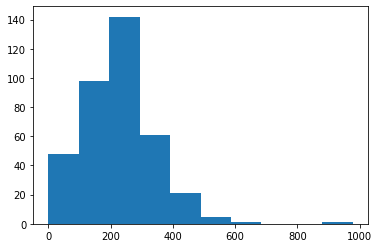

In [ ]:
len_abstracts = []
for i in range(len(abstracts)):
    len_abstracts.append(len(int_abstracts[i]))

plt.hist(len_abstracts)

Si je prends une longueur maximale de 400 ça devrait couvrir la plupart des titres qu'on a .On convertit maintenant en pytorch pour pouvoir les utiliser par la suite dans nos modèles.

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len = 400 
batch_size = 64 #128  
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

X = torch.zeros((len(int_abstracts),max_len)).long()

for i, text in enumerate(int_abstracts):
  lenght = min(max_len,len(text))
  X[i,:lenght] = torch.LongTensor(text[:lenght])

Y = torch.tensor(labels)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([377, 400]) torch.Size([377])
tensor([584, 585,   7, 586, 343, 118,  26,  27,  28, 317, 587, 588,   2, 589,
        590, 591, 592,   1, 292,  58, 118, 593, 594, 595, 596, 155, 597, 598,
         12, 599, 118, 300,  58, 600,   7, 601, 118, 602,  58, 603,  25, 592,
        604, 605, 606,   5, 607, 608,  81, 606, 609, 610,  58,   2, 611, 612,
         54, 219, 613, 614,   3, 615, 616, 407, 617, 618, 619, 620,   7, 621,
        622, 407, 623,  58, 541,   7, 624, 605, 625, 622, 626, 627, 628, 629,
        630, 407, 631,   7, 632, 633, 407, 634, 635,   2, 636,   5, 637, 638,
        639,   7, 640, 407, 634, 641,   7, 642, 643, 644, 645, 646, 153,   2,
        122, 647, 349, 648, 649, 650, 651,  19, 652, 653,  25, 654, 655, 656,
          7, 153,   2, 634, 647, 349, 657,   5,  99,  57, 649, 654, 116,  49,
         19, 274, 658, 583, 520,  58, 201, 659, 522, 660, 579, 525,  94, 658,
        487,  25, 661, 662, 586, 663, 118, 664,  58, 118, 665, 666, 667,  85,
        668, 669, 670, 

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([263, 400])
torch.Size([114, 400])
torch.Size([263])
torch.Size([114])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

Fonction de loss et fit : je réutilise celle du tp3 

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(labels))
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        drop = self.dropout(hidden)
        return self.decision(drop.transpose(0, 1).contiguous().view(x.size(0), -1))

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(13505, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=377, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5])

tensor([[-0.1499,  0.1934,  0.1364,  ..., -0.0464,  0.1623, -0.1158],
        [-0.2210,  0.2052,  0.7316,  ...,  0.6942,  0.2804, -0.4465],
        [-0.1767,  0.4722,  0.0920,  ..., -0.0228, -0.0728, -0.2447],
        [-0.4372,  0.1590, -0.1523,  ...,  0.3339,  0.5387, -0.4422],
        [-0.1385,  0.0228,  0.1587,  ...,  0.3201,  0.2140, -0.5138]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_model,30)  #la loss diminue bien sur les données d'apprentissage, par contre l'accuracy pas fameux 

0 0.10027956509318188 0.07707794507344563 0.3684210526315789
1 0.07513592633004425 0.05669806714643512 0.3684210526315789
2 0.05721726798286003 0.0452429453531901 0.37719298245614036
3 0.046601640407576764 0.03930898298297012 0.38596491228070173
4 0.04111984338143933 0.03593088764893381 0.38596491228070173
5 0.03619091547034086 0.03191210721668444 0.39473684210526316
6 0.03280074016222936 0.03042732414446379 0.39473684210526316
7 0.03324575342606229 0.029939115047454834 0.39473684210526316
8 0.032959518323833044 0.02968187499464604 0.39473684210526316
9 0.032067835104329506 0.029558106472617703 0.39473684210526316
10 0.032263102186949985 0.029529398993441935 0.39473684210526316
11 0.032420763044756176 0.029549381189179002 0.39473684210526316
12 0.03226338729205694 0.02952523712526288 0.39473684210526316
13 0.03140630785503315 0.02944265227568777 0.39473684210526316
14 0.03190599149624204 0.029393401062279417 0.39473684210526316
15 0.03229274178639111 0.029399025858494274 0.394736842105

Remarque : Quand je fais 20 epochs ==> il surapprend ( on a pas un grand dataset), c'est déjà visible sur 10 epochs ! 

##Application du CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(labels))

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))  
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (embed): Embedding(13505, 128)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=377, bias=True)
)

In [ ]:
cnn_model(X[:5])

tensor([[ 0.2836, -1.6487, -1.5079,  ..., -0.5748,  1.1210, -0.4601],
        [-0.1078, -0.0753, -2.0405,  ...,  0.0429,  0.8769,  0.4000],
        [-0.2340, -0.1392, -1.8061,  ..., -0.1306, -0.5380, -0.1503],
        [-0.3872,  0.6462, -1.5825,  ..., -0.6003,  0.0072,  1.1719],
        [-0.2383,  0.2714, -0.1339,  ...,  0.0187,  0.0432,  0.1562]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(cnn_model,30) #la loss diminue aussi et l'accuracy est déjà meilleurP

0 0.12236239973583149 0.08518661532485694 0.0
1 0.07721050882520784 0.051479061444600425 0.38596491228070173
2 0.04579066550323718 0.03595988792285584 0.38596491228070173
3 0.033778860541804206 0.0316834711191947 0.38596491228070173
4 0.029104372621035848 0.029932470698105663 0.38596491228070173
5 0.026940151765772597 0.029385656641240706 0.38596491228070173
6 0.02544219287629363 0.028963574191980195 0.39473684210526316
7 0.023279697836125306 0.028516341719711034 0.39473684210526316
8 0.021918648039433438 0.028483362574326366 0.39473684210526316
9 0.021517041858158184 0.028236855540359228 0.39473684210526316
10 0.020161256930673985 0.028060959096540484 0.41228070175438597
11 0.019270343528954247 0.027995544567442777 0.42105263157894735
12 0.01836614322073106 0.027790273490704988 0.40350877192982454
13 0.01893038373482998 0.027699512347840426 0.39473684210526316
14 0.017350374405828265 0.027605854628378886 0.39473684210526316
15 0.017315487557944237 0.02754185492532295 0.394736842105263

Pareil surapprentissage à partir de la 16 ème epoch, sur 10 epochs il est bon mais l'accuracy redescend .

##Application du RNN+CNN 

In [ ]:
class RNN_CNN(nn.Module): #But sortie du RNN en entrée du CNN  #je declare toutes mes couches
    def __init__(self): 
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)  # (batch,seq_len,hidden_size*num_directions) 
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(labels))

    def forward(self, x): #afficher la taille au fur et à mesure - utiliser des nombers premiers pour tester 
                        #je veux un tenseur de taille (batch,seq_len,hidden_size*num_directions)
        embed = self.embed(x)
        output,hidden = self.rnn(embed)
        conv = F.relu(self.conv(output.transpose(1,2))) #.transpose(1,2))) #la couche de convolution veut cette taille en entrée(batch_size, embedding_size, sequence_length)
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

rnn_cnn_model = RNN_CNN()
rnn_cnn_model.to(device)

RNN_CNN(
  (embed): Embedding(13505, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=377, bias=True)
)

In [ ]:
rnn_cnn_model(X[:5])

tensor([[ 0.0043, -0.0860,  0.0437,  ...,  0.3163, -0.0737,  0.1714],
        [ 0.1210,  0.3009,  0.1580,  ...,  0.3593, -0.1456,  0.0022],
        [ 0.4837,  0.2122, -0.1768,  ...,  0.1851, -0.1135, -0.0220],
        [ 0.0442,  0.3965, -0.0325,  ...,  0.3198,  0.1662, -0.0688],
        [ 0.1387,  0.0181,  0.2754,  ...,  0.1259,  0.0025, -0.2674]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_cnn_model,30)

0 0.10905323826314832 0.09053886145876165 0.19298245614035087
1 0.08798298998930608 0.0692652986760725 0.19298245614035087
2 0.06079209440108035 0.04354704890334815 0.21052631578947367
3 0.03970529643301728 0.0329503573869404 0.41228070175438597
4 0.033051537016951994 0.030344125471617047 0.37719298245614036
5 0.03261022060089692 0.029344020182626288 0.37719298245614036
6 0.02988586702274279 0.0289600460152877 0.37719298245614036
7 0.02831188014251651 0.028903318078894364 0.37719298245614036
8 0.028003254544145706 0.028766203344913952 0.37719298245614036
9 0.026878815413427896 0.02861778045955457 0.37719298245614036
10 0.025184010484825974 0.028489034426839727 0.37719298245614036
11 0.024870415150892597 0.02840662734550342 0.37719298245614036
12 0.024025435456758216 0.028329256333802875 0.38596491228070173
13 0.022791976937776282 0.02832748074280588 0.38596491228070173
14 0.0214890616701583 0.028244681525648685 0.38596491228070173
15 0.020910017617301796 0.02809124034747743 0.385964912

PAreil le modèle n'arrive pas à bien apprendre car le dataset est beaucoup trop petit 

## Comparaison des résultats 

Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour les modèles choisis : RNN, CNN et RNN + CNN. Nous faisons varier les paramètres suivant : le nombre de batch et le nombre d'epochs. On note pour chaque modèle l'accuracy et la loss obtenue (**loss/accuracy**).

*A noter que lorsqu'on fait varier le batch_size on se limite à des epochs de 10 et lorsqu'on fait varier le nombre d'epochs on fixe le nombre de batch à 64*

(*) Remarque : Pour le modèle CNN et RNN+CNN on observe que l'accuracy diminue puis réaugmente, en augmentant le nombre de batch on aimerait augmenter en efficacité mais là on fait du surapprentissage.

(**) Remarque : A partir de la 12 ème epoch pour le modèle RNN la loss augmente et l'accuracy stagne ==> sur-apprentissage 

|Loss/Accuracy (en %) || RNN | CNN | RNN+CNN |
|----------||----------|----------|----------|
| batch_size **64**   || 3 / 32 | 2 / 32 | 2,8 / 32 |
| batch_size **128** || 2,1 / 35 | 1,3 / 25 * | 1,7 / 35 *  |
| epochs **30** || 3,2 / 39 ** | 1 / 45 | 0,9 / 39 |


# Contenu 3 : Titre + Abstract  
Dans ce notebook nous allons tester un modèle qui prend en compte **les titres et les abstracts** à la fois pour prédire les **catégories** sur le dataset de **Bibliocovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances du modèle RNN pour les titres seuls, les abstracts seuls puis les deux réunis. 

#Initialisation 

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


In [ ]:
# import os 
# os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

On récupère les fichiers json 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json

In [ ]:
bibliovid_file = open('data/bibliovid.json')
# litcovid_file = open('./litcovid.json')

data_bibliovid = json.loads(bibliovid_file.read())
# data_litcovid = json.loads(litcovid_file.read())

bibliovid_file.close()
# litcovid_file.close()

In [ ]:
print(data_bibliovid[0])
# print(data_litcovid[0])

{'id': 769, 'slug': 'body-mass-index-and-risk-for-intubation-or-death-in-sars-cov-2-infection-a-retro', 'title': 'Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study', 'has_other_authors': True, 'impact_factor': {'id': 3, 'name': 'Intermédiaire', 'posts_count': 149, 'color': 'orange', 'order': 2}, 'goals_plain': "- Déterminer si l'obésité est associée à l'intubation ou le décès au cours de l'infection au SARS-CoV-2 - Déterminer si l'obésité est associée à l'inflammation , aux lésions cardiaques ou à la fibrinolyse dans la COVID-19", 'verbose_date': '31.07.2020', 'authors': 'Anderson MR', 'document_link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'specialties': [{'id': 4, 'name': 'Anesthésie-Réanimation'}, {'id': 12, 'name': 'Infectiologie'}], 'category': {'id': 6, 'name': 'Pronostique', 'icon': 'icon-chat'}, 'journal': {'id': 41, 'name': 'Ann Intern Med'}, 'link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'results':

#Bibliovid : prediction de categories en fonction des abstracts et titres à la fois 


In [ ]:
print(data_bibliovid[0]['abstract'])
print(data_bibliovid[0]['title'])
print(data_bibliovid[0]['category']['id'])


Obesity is a risk factor for pneumonia and acute respiratory distress syndrome.
To determine whether obesity is associated with intubation or death, inflammation, cardiac injury, or fibrinolysis in coronavirus disease 2019 (COVID-19).
Retrospective cohort study.
A quaternary academic medical center and community hospital in New York City.
2466 adults hospitalized with laboratory-confirmed severe acute respiratory syndrome coronavirus 2 infection over a 45-day period with at least 47 days of in-hospital observation.
Body mass index (BMI), admission biomarkers of inflammation (C-reactive protein [CRP] level and erythrocyte sedimentation rate [ESR]), cardiac injury (troponin level), and fibrinolysis (D-dimer level). The primary end point was a composite of intubation or death in time-to-event analysis.
Over a median hospital length of stay of 7 days (interquartile range, 3 to 14 days), 533 patients (22%) were intubated, 627 (25%) died, and 59 (2%) remained hospitalized. Compared with over

In [ ]:
abstracts = []
text_titles = []
labels = []
miss_data = []

for i in range(len(data_bibliovid)):
  if 'abstract' in data_bibliovid[i] and data_bibliovid[i]['abstract'] != None : 
    abstracts.append(data_bibliovid[i]['abstract'])
    text_titles.append(data_bibliovid[i]['title'])
    labels.append(data_bibliovid[i]['category']['id']) 
  else : 
    miss_data.append(data_bibliovid[i]['id'])

print(abstracts[3])
print(text_titles[3])
print(labels[3])

print(len(abstracts))
print(len(text_titles))
print(len(miss_data)) # c'est la moitié quand même 

Following SARS-CoV-2 emergence in China, a specific surveillance was implemented in France. Phylogenetic analysis of sequences retrieved through this surveillance suggests that detected initial introductions, involving non-clade G viruses, did not seed local transmission. Nevertheless, identification of clade G variants subsequently circulating in the country, with the earliest from a patient who neither travelled to risk areas nor had contact with travellers, suggests that SARS-CoV-2 might have been present before the first recorded local cases.
Introductions and Early Spread of SARS-CoV-2 in France, 24 January to 23 March 2020
5
377
377
305


In [ ]:
categories = {} # 7 catgéories 

for i in range(len(data_bibliovid)):
  categories[data_bibliovid[i]['category']['id']] = data_bibliovid[i]['category']['name']

print(categories)

{6: 'Pronostique', 8: 'Modélisation', 4: 'Thérapeutique', 2: 'Autres', 5: 'Epidémiologique', 3: 'Diagnostique', 7: 'Recommandations'}


## Préparation du dataset 

on  transforme les textes en entiers 

In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))  #on prend le meme vocabulaire pour les abstracts et les titres : on vérifie bien avec #in Marseille "
                                                        #il est converti avec les entiers 25 et 1056 dans le titre et l'abstract donc c'est bon :) "

int_abstracts = []
for text in abstracts : 
  int_abstracts.append([vocab[token] for token in text.split()])

print(int_abstracts[10])
print(abstracts[10]) 

int_titles = []
for text in text_titles : 
    int_titles.append([vocab[token] for token in text.split()])

print(int_titles[10])
print(text_titles[10])  

[465, 699, 1055, 25, 1056, 1057, 1058, 787, 1059, 7, 1060, 615, 5, 26, 27, 28, 29, 1061, 7, 1059, 531, 17, 1062, 7, 1063, 1064, 85, 1065, 5, 118, 656, 583, 191, 1066, 942, 118, 538, 339, 58, 1067, 1068, 115, 197, 1069, 1070, 1071, 17, 1072, 1073, 1074, 58, 1075, 1076, 288, 1077, 1078, 5, 1079, 57, 7, 1080, 1074, 58, 1075, 1081, 407, 1082, 650, 1083, 255, 214, 1074, 1078, 5, 118, 1084, 1000, 360, 1085, 5, 54, 55, 288, 57, 7, 1086, 1087, 102, 1071, 17, 781, 1088, 1089, 1090, 104, 20, 1091, 98, 118, 425, 451, 1092, 1093, 1094, 57, 58, 974, 7, 1095, 1096, 81, 1097, 233, 813, 85, 198, 1098, 1099, 163, 1100, 104, 948, 7, 118, 494, 495, 74, 85, 1101, 191, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 25, 1112, 58, 118, 1113, 1114, 102, 17, 1115, 538, 364, 1116, 1117, 1118, 1119, 33, 1120, 743, 1121, 1122, 1123, 7, 1110, 1111, 85, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1126, 1132, 1133, 1134, 25, 721, 1135, 7, 327, 25, 1136, 383, 384, 1137, 1138, 884, 7, 881, 1139, 7, 11

In [ ]:
print(len(int_abstracts))
print(len(int_titles))
print(len(labels))

377
377
377


conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_abstracts[10]]) # c'est bon 
print([rev_vocab[word_id] for word_id in int_titles[10]]) # c'est bon 

['In', 'our', 'institute', 'in', 'Marseille,', 'France,', 'we', 'initiated', 'early', 'and', 'massive', 'screening', 'for', 'coronavirus', 'disease', '2019', '(COVID-19).', 'Hospitalization', 'and', 'early', 'treatment', 'with', 'hydroxychloroquine', 'and', 'azithromycin', '(HCQ-AZ)', 'was', 'proposed', 'for', 'the', 'positive', 'cases.', 'We', 'retrospectively', 'report', 'the', 'clinical', 'management', 'of', '3,737', 'screened', 'patients,', 'including', '3,119', '(83.5%)', 'treated', 'with', 'HCQ-AZ', '(200', 'mg', 'of', 'oral', 'HCQ,', 'three', 'times', 'daily', 'for', 'ten', 'days', 'and', '500', 'mg', 'of', 'oral', 'AZ', 'on', 'day', '1', 'followed', 'by', '250', 'mg', 'daily', 'for', 'the', 'next', 'four', 'days,', 'respectively)', 'for', 'at', 'least', 'three', 'days', 'and', '618', '(16.5%)', 'patients', 'treated', 'with', 'other', 'regimen', '("others").', 'Outcomes', 'were', 'death,', 'transfer', 'to', 'the', 'intensive', 'care', 'unit', '(ICU),', '≥10', 'days', 'of', 'hosp

(array([ 6., 29., 76., 69., 70., 61., 34., 23.,  7.,  2.]),
 array([ 4. ,  6.4,  8.8, 11.2, 13.6, 16. , 18.4, 20.8, 23.2, 25.6, 28. ]),
 <a list of 10 Patch objects>)

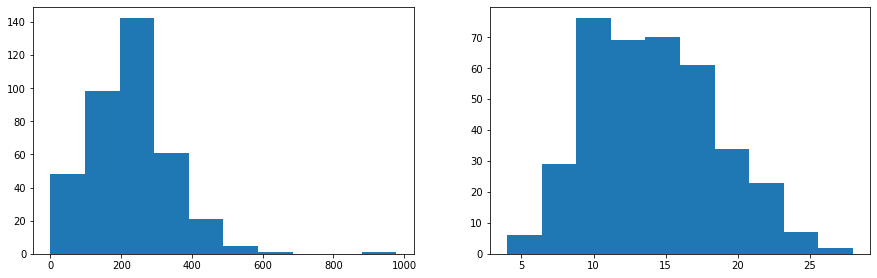

In [ ]:
len_abstracts = []
for i in range(len(abstracts)):
    len_abstracts.append(len(int_abstracts[i]))

len_titles = []
for i in range(len(int_titles)):
    len_titles.append(len(int_titles[i]))

fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)  
plt.hist(len_abstracts)

plt.subplot(2,2,2) 
plt.hist(len_titles)

Si je prends une longueur maximale de 400 ça devrait couvrir la plupart des abstracts qu'on a . Si on prend une longueur maximale de 20 on couvrirait la plupart des titres. On convertit maintenant en pytorch pour pouvoir les utiliser par la suite dans nos modèles.

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len_abstract = 400
max_len_title = 20  
max_len = max_len_abstract + max_len_title
batch_size = 64  
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

#X = X_title+ X_abstract 
X_title = torch.zeros((len(int_titles),max_len_title)).long()
X_abstract = torch.zeros((len(int_abstracts),max_len_abstract)).long()

for i, text in enumerate(int_abstracts): 
  lenght = min(max_len_abstract,len(text))
  X_abstract[i,:lenght] = torch.LongTensor(text[:lenght])

for i, text in enumerate(int_titles): 
  lenght = min(max_len_title,len(text)) 
  X_title[i,:lenght] = torch.LongTensor(text[:lenght])

X = torch.cat((X_abstract,X_title),-1)
Y = torch.tensor(labels)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([377, 420]) torch.Size([377])
tensor([  584,   585,     7,   586,   343,   118,    26,    27,    28,   317,
          587,   588,     2,   589,   590,   591,   592,     1,   292,    58,
          118,   593,   594,   595,   596,   155,   597,   598,    12,   599,
          118,   300,    58,   600,     7,   601,   118,   602,    58,   603,
           25,   592,   604,   605,   606,     5,   607,   608,    81,   606,
          609,   610,    58,     2,   611,   612,    54,   219,   613,   614,
            3,   615,   616,   407,   617,   618,   619,   620,     7,   621,
          622,   407,   623,    58,   541,     7,   624,   605,   625,   622,
          626,   627,   628,   629,   630,   407,   631,     7,   632,   633,
          407,   634,   635,     2,   636,     5,   637,   638,   639,     7,
          640,   407,   634,   641,     7,   642,   643,   644,   645,   646,
          153,     2,   122,   647,   349,   648,   649,   650,   651,    19,
          652,   653,  

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([263, 420])
torch.Size([114, 420])
torch.Size([263])
torch.Size([114])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

Fonction de loss et fit : on doit les adapter car cette fois on a les titres et les abstracts à prendre en compte

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #on modifie la fonction de loss également 
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        x_abstract = x[:,:max_len_abstract]
        x_title = x[:,max_len_abstract:]
        y_scores = model(x_abstract,x_title)
        loss = criterion(y_scores, y)
        # y_pred = y_scores > 0.5 
        y_pred = torch.max(y_scores,1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs): #train_loader, test_loader,
    criterion = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #on modifie la fonction de loss également 
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x_abstract = x[:,:max_len_abstract]
            x_title = x[:,max_len_abstract:]
            y_scores = model(x_abstract,x_title)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn_abstract = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.rnn_title = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout_abstract = nn.Dropout(0.3)
        self.dropout_title = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 2 , len(labels)) #on a deux couches
        
    def forward(self,x_abstract,x_title):
        embed_abstract = self.embed(x_abstract)
        embed_title = self.embed(x_title)
        output_abstract, hidden_abstract = self.rnn_abstract(embed_abstract)
        output_title, hidden_title = self.rnn_title(embed_title)
        drop_abstract = self.dropout_abstract(hidden_abstract).squeeze(0)
        drop_title = self.dropout_title(hidden_title).squeeze(0)
        cat = torch.cat((drop_abstract,drop_title),-1)
        return self.decision(cat.contiguous())

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(14038, 128)
  (rnn_abstract): GRU(128, 128, batch_first=True)
  (rnn_title): GRU(128, 128, batch_first=True)
  (dropout_abstract): Dropout(p=0.3, inplace=False)
  (dropout_title): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=256, out_features=377, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5,:max_len_abstract],X[:5,max_len_abstract:])

tensor([[-2.0208e-01, -3.9787e-01, -3.0315e-01,  ...,  3.7851e-01,
          4.3518e-01,  1.2859e-01],
        [ 6.7135e-02, -4.6755e-01, -1.8667e-01,  ...,  4.2987e-02,
          2.0751e-01,  2.8145e-02],
        [-1.1942e-01,  2.3353e-02,  1.1537e-01,  ...,  1.1619e-01,
         -6.5248e-02,  4.4707e-01],
        [ 1.2046e-01, -6.1232e-01,  5.8103e-04,  ...,  3.0215e-01,
          4.3287e-01,  1.1190e-01],
        [-2.1500e-01, -2.8843e-01, -2.2776e-01,  ...,  1.3435e-01,
         -4.5568e-02,  4.2018e-01]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_model,10)  #la loss diminue bien sur les données d'apprentissage, par contre l'accuracy pas fameux 

0 0.09588864728978379 0.06262560267197459 0.39473684210526316
1 0.060048599206902684 0.04248976916597601 0.40350877192982454
2 0.04385614576448506 0.036366213831985204 0.39473684210526316
3 0.03795096538819288 0.03464639500567788 0.3684210526315789
4 0.03510260763277119 0.0330376802829274 0.37719298245614036
5 0.03441557231511453 0.03145172826030798 0.38596491228070173
6 0.032774990502419124 0.030614253721739117 0.3684210526315789
7 0.032925008820943506 0.03046338913733499 0.39473684210526316
8 0.031494193204002235 0.03054602627168622 0.39473684210526316
9 0.030736122747791132 0.030506826283638936 0.40350877192982454


## Comparaison des résultats avec title et abstract 


Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour le RNN selon qu'on ait prédit les catégories à partir des titres, des abstracts puis des deux. (**loss/accuracy**).

On fixe le **batch_size = 64** et le **nombre d'epochs à 10** 

(*) Remarque :La différence de performance du modèle entre le titre et l'asbtract s'explique par les miss_datas : en effet pour les abstracts il y'a près de la moitié du dataset qui manque donc on se retrouve avec un très petit dataset 

(**) Remarque :La meilleure performance est obtenue lorsqu'on prend les titres et les abstracts conjointement ==> le modèle a beaucoup plus de matière sur laquelle apprendre d'autant plus que le titre et l'abstract sont reliés et partagent le même vocabulaire 

(***) Remarque : Nos résultats restent peu satisaisants, les raisons que nous pouvons suspecter: 
- notre dataset est trop petit (377 lorsqu'on enleve les data sans abstract) ; 
- notre modèle n'est pas le plus adapté (on pourrait encore essayer CNN ou RNN+CNN)




|RNN || Title | Abstract | Title + Abstract |
|----------||----------|----------|----------|
| Loss (en %) || 3  | 29 | 3|
| Accuracy (en %) || 32 | 33 |  40 |


# Contenu 4 : Nom du journal 
Dans ce notebook nous allons tester trois modèles **RNN, CNN et RNN+CNN** pour prédire les **catégories** à partir du **nom du journal** dans lequel l'article a été publié sur le dataset de **BiblioCovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances des modèles choisis . 

#Initialisation 

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


In [ ]:
# import os 
# os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

On récupère les fichiers json 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json

--2021-01-05 18:34:19--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/bibliovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3850131 (3.7M) [application/json]
Saving to: ‘data/bibliovid.json’

bibliovid.json      100%[===================>]   3.67M  16.0MB/s    in 0.2s    

2021-01-05 18:34:19 (16.0 MB/s) - ‘data/bibliovid.json’ saved [3850131/3850131]

FINISHED --2021-01-05 18:34:19--
Total wall clock time: 0.4s
Downloaded: 1 files, 3.7M in 0.2s (16.0 MB/s)


In [ ]:
bibliovid_file = open('data/bibliovid.json')
# litcovid_file = open('./litcovid.json')

data_bibliovid = json.loads(bibliovid_file.read())
# data_litcovid = json.loads(litcovid_file.read())

bibliovid_file.close()
# litcovid_file.close()

In [ ]:
print(data_bibliovid[0])
# print(data_litcovid[0])

{'id': 769, 'slug': 'body-mass-index-and-risk-for-intubation-or-death-in-sars-cov-2-infection-a-retro', 'title': 'Body Mass Index and Risk for Intubation or Death in SARS-CoV-2 Infection: A Retrospective Cohort Study', 'has_other_authors': True, 'impact_factor': {'id': 3, 'name': 'Intermédiaire', 'posts_count': 149, 'color': 'orange', 'order': 2}, 'goals_plain': "- Déterminer si l'obésité est associée à l'intubation ou le décès au cours de l'infection au SARS-CoV-2 - Déterminer si l'obésité est associée à l'inflammation , aux lésions cardiaques ou à la fibrinolyse dans la COVID-19", 'verbose_date': '31.07.2020', 'authors': 'Anderson MR', 'document_link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'specialties': [{'id': 4, 'name': 'Anesthésie-Réanimation'}, {'id': 12, 'name': 'Infectiologie'}], 'category': {'id': 6, 'name': 'Pronostique', 'icon': 'icon-chat'}, 'journal': {'id': 41, 'name': 'Ann Intern Med'}, 'link': 'https://www.acpjournals.org/doi/10.7326/M20-3214', 'results':

#Bibliovid : prediction de categories en fonction des journaux 

Quelles sont les colonnes qui nous intéressent ?

**Dans bibliovid :**

Pour la prédiction de catégories

* journal
* category 


Dans un premier temps : 

--> Je prédis la catégorie en fonction du titre 

In [ ]:
print(data_bibliovid[0]['journal'])
print(data_bibliovid[0]['category']['id'])

{'id': 41, 'name': 'Ann Intern Med'}
6


In [ ]:
journal_names = []
labels = []

for i in range(len(data_bibliovid)):
  journal_names.append(data_bibliovid[i]['journal']['name'])
  labels.append(data_bibliovid[i]['category']['id']) #je vais chercher que l'id de la catégorie correspondante : pas besoin de normaliser 

print(journal_names[3])
print(labels[3])
#le 3 eme document appartient à la catégorie 4 

print(len(journal_names))
print(np.max(labels)) #ça me donne une idée du nombre de catégorie existante : il y'en a 8 

Nature
4
682
8


In [ ]:
categories = {} # 7 catgéories 

for i in range(len(data_bibliovid)):
  categories[data_bibliovid[i]['category']['id']] = data_bibliovid[i]['category']['name']

print(categories)

{6: 'Pronostique', 8: 'Modélisation', 4: 'Thérapeutique', 2: 'Autres', 5: 'Epidémiologique', 3: 'Diagnostique', 7: 'Recommandations'}


## Préparation du dataset 

In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))

int_journal_names = []
for name in journal_names : 
    int_journal_names.append([vocab[token] for token in name.split()])

print(int_journal_names[10])
print(journal_names[10])  

[10, 8, 11]
Wellcome Open Research


conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_journal_names[10]]) # c'est bon 

['Wellcome', 'Open', 'Research']


Pour décider de max_len plus tard il faut qu'on voit la longueur maximale de titre qu'on a 

(array([227.,   0., 117.,   0., 236.,   0.,  70.,   0.,  22.,  10.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

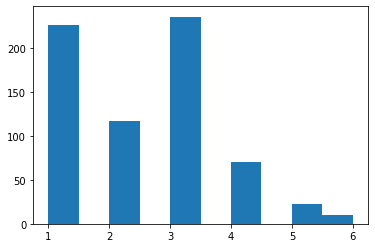

In [ ]:
len_names = []
for i in range(len(int_journal_names)):
    len_names.append(len(int_journal_names[i]))

plt.hist(len_names)

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len = 6 
batch_size = 64 #128 #
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

X = torch.zeros((len(int_journal_names),max_len)).long()

for i, text in enumerate(int_journal_names):
  lenght = min(max_len,len(text))
  X[i,:lenght] = torch.LongTensor(text[:lenght])


Y = torch.tensor(labels)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([682, 6]) torch.Size([682])
tensor([5, 0, 0, 0, 0, 0], device='cuda:0') tensor(4, device='cuda:0')


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([477, 6])
torch.Size([205, 6])
torch.Size([477])
torch.Size([205])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

Fonction de loss et fit : je réutilise celle du tp3 

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab),embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(labels))
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        drop = self.dropout(hidden)
        return self.decision(drop.transpose(0, 1).contiguous().view(x.size(0), -1))

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(300, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=682, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5])

tensor([[ 0.0728, -0.0063, -0.4166,  ...,  0.1171,  0.3447,  0.2497],
        [ 0.4202,  0.0111, -0.3187,  ...,  0.2329,  0.4297,  0.3615],
        [ 0.2328,  0.0651, -0.7194,  ...,  0.5205,  0.4830,  0.6875],
        [ 0.0850,  0.4312, -0.4419,  ...,  0.5139,  0.6668,  0.6740],
        [-0.0178,  0.3635, -0.4226,  ...,  0.1512,  0.7490,  0.3672]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_model,10)  #la loss diminue bien sur les données d'apprentissage, par contre l'accuracy pas fameux 

0 0.0927298293923432 0.08655709057319455 0.2731707317073171
1 0.05987160660685733 0.054202760138162755 0.2731707317073171
2 0.03983365614709115 0.041597748384243106 0.2731707317073171
3 0.03301153942723944 0.03712024339815465 0.2731707317073171
4 0.03017967027188347 0.03573752263697182 0.2780487804878049
5 0.029331101561492344 0.03536351657495266 0.2780487804878049
6 0.02907779281744167 0.03515266092812143 0.2731707317073171
7 0.028564132734414667 0.03505885368440209 0.2731707317073171
8 0.02808873883333346 0.03495221835810964 0.2731707317073171
9 0.028234073201065545 0.034862103113314 0.2780487804878049


##Application du CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(labels))

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))  
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (embed): Embedding(300, 128)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=682, bias=True)
)

In [ ]:
cnn_model(X[:5])

tensor([[-0.2413, -0.4169, -0.2116,  ...,  0.2977, -0.7421,  0.1225],
        [-0.1429,  0.2266, -0.0853,  ..., -0.2247, -0.3144, -0.5018],
        [-0.2026, -0.5063,  0.0302,  ...,  0.0112, -0.4558, -0.5167],
        [ 0.2471,  0.1273, -0.0255,  ..., -0.2570, -0.4004, -0.5827],
        [-0.2281, -0.0170,  0.0865,  ..., -0.2023, -0.6064, -0.3520]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(cnn_model,10) #la loss diminue aussi et l'accuracy est déjà meilleurP

0 0.017831474480139133 0.038279919508026866 0.32195121951219513
1 0.01663468618812801 0.03813716202247434 0.32195121951219513
2 0.016584093090873095 0.03850213725392412 0.2975609756097561
3 0.01648649117231869 0.038728757020903795 0.3024390243902439
4 0.016352219776537433 0.038874362736213496 0.32195121951219513
5 0.016090694338520617 0.039299351413075514 0.3121951219512195
6 0.015873881755884837 0.0391635330711923 0.3073170731707317
7 0.016266579897898547 0.039057472275524606 0.33170731707317075
8 0.015988764647917677 0.03915847045619313 0.32682926829268294
9 0.01578115442264005 0.03939503867451737 0.3170731707317073


Pareil avec un batch size plus important l'accuracy augmente aussi mais c'est léger 

##Application du RNN+CNN 

In [ ]:
class RNN_CNN(nn.Module): #But sortie du RNN en entrée du CNN  #je declare toutes mes couches
    def __init__(self): 
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)  # (batch,seq_len,hidden_size*num_directions) 
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(labels))

    def forward(self, x): #afficher la taille au fur et à mesure - utiliser des nombers premiers pour tester 
                        #je veux un tenseur de taille (batch,seq_len,hidden_size*num_directions)
        embed = self.embed(x)
        output,hidden = self.rnn(embed)
        conv = F.relu(self.conv(output.transpose(1,2))) #.transpose(1,2))) #la couche de convolution veut cette taille en entrée(batch_size, embedding_size, sequence_length)
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

rnn_cnn_model = RNN_CNN()
rnn_cnn_model.to(device)

RNN_CNN(
  (embed): Embedding(300, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=682, bias=True)
)

In [ ]:
rnn_cnn_model(X[:5])

tensor([[ 0.0769,  0.1407,  0.2597,  ...,  0.0952,  0.1741,  0.0121],
        [ 0.0433,  0.2077,  0.3051,  ...,  0.0561,  0.0044,  0.0662],
        [-0.0152,  0.1797,  0.2176,  ...,  0.0312,  0.0086,  0.1228],
        [-0.0556,  0.2213,  0.2042,  ..., -0.0062, -0.0590,  0.0272],
        [ 0.1962,  0.1627,  0.2792,  ..., -0.0172, -0.0028,  0.2884]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_cnn_model,10)

0 0.016431338132302468 0.04561316792557879 0.3853658536585366
1 0.015863603890816872 0.04300439881115425 0.3170731707317073
2 0.01493128990477236 0.04359523959276153 0.3073170731707317
3 0.01462733495660298 0.043756725729965584 0.28292682926829266
4 0.015237318144904243 0.04392475732942907 0.3024390243902439
5 0.014645170615654072 0.04430048058672649 0.3073170731707317
6 0.014916474464304542 0.04480070369999583 0.34146341463414637
7 0.01451981854888628 0.04492248791020091 0.32682926829268294
8 0.014887883228325995 0.04463114971067847 0.3121951219512195
9 0.01451557999636892 0.04479535149364937 0.3463414634146341


## Comparaison des résultats 

Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour les modèles choisis : RNN, CNN et RNN + CNN. Nous affichons la **loss et l'accuracy**.

(*) Remarque : les performances ne sont pas satisfaisantes : mais elles ne sont pas si basses donc il peut être pertinent de prendre le nom du journal comme critère pour prédire les catégories, le coupler avec le titre et l'abstract 


|batch_size = 64 /epochs = 10 || RNN | CNN | RNN+CNN |
|----------||----------|----------|----------|
| Loss (en %)   || 3 | 1 | 1 |
| Accuracy (en %)  || 28 |32 | 34  |



# Contenu 5 : Titres sur LitCovid  
Dans ce notebook nous allons tester trois modèles **RNN, CNN et RNN+CNN** pour prédire les **catégories** à partir du **titre** de l'article sur le dataset de **LitCovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances des modèles choisis en fonction de certains paramètres que nous avons choisi de faire varier. 

#Initialisation 

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


In [ ]:
# import os 
# os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json

--2021-01-05 18:41:03--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104815092 (100M) [application/json]
Saving to: ‘data/litcovid.json’

litcovid.json       100%[===================>]  99.96M  14.6MB/s    in 8.1s    

2021-01-05 18:41:13 (12.3 MB/s) - ‘data/litcovid.json’ saved [104815092/104815092]

FINISHED --2021-01-05 18:41:13--
Total wall clock time: 9.6s
Downloaded: 1 files, 100M in 8.1s (12.3 MB/s)


On récupère les fichiers json 

In [ ]:
# bibliovid_file = open('./bibliovid.json')
litcovid_file = open('data/litcovid.json')

# data_bibliovid = json.loads(bibliovid_file.read())
data_litcovid = json.loads(litcovid_file.read())

# bibliovid_file.close()
litcovid_file.close()

In [ ]:
# print(data_bibliovid[0])
print(data_litcovid[0])

{'pmid': 33273934, 'pmcid': 'PMC7698443', 'title': 'Cardiac anesthesia and COVID-19 outbreak: What should we know?', 'journal': 'J Res Med Sci', 'authors': ['Ziyaeifard, Mohsen', 'Ziyaeifard, Parisa'], 'date': '2020-12-05T12:00:00Z', '_id': '33273934', 'topics': ['Prevention'], 'text_hl': None, 'abstract': 'The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidel

#Litcovid : prediction des catégories en fonction des titres 

In [ ]:
print(data_litcovid[0]['title'])
print(data_litcovid[0]['topics'])
print(len(data_litcovid))

Cardiac anesthesia and COVID-19 outbreak: What should we know?
['Prevention']
77522


Je commence par récupérer que ceux qui ont topics en key 

In [ ]:
titles = []
labels = {}
# miss_topics = []
# miss_titles = []
miss_data = []

for i in range(len(data_litcovid)):
  if 'title' in data_litcovid[i] and 'topics' in data_litcovid[i] : 
    titles.append(data_litcovid[i]['title'])
  # else : 
  #   miss_titles.append(i)
    labels[i] = (len(data_litcovid[i]['topics']),data_litcovid[i]['topics'])
  else : 
    miss_data.append(i)


In [ ]:
print(miss_titles) #un seul titre qui manque 
print(len(miss_topics)) # 30% de la data n'a pas de key topics
print(len(miss_data))

[73444]
22793
22793


##Les topics 

Ce que je vais faire pour commencer c'est prendre pour chacun la première catégorie, après peut-être que je pourrais en prendre plus mais je ne sais pas encore comment gérer ça 

In [ ]:
list(labels.values())[0][1][0]

'Prevention'

In [ ]:
topic_tronque = [0]*len(labels)

for i in range(len(list(labels.values()))) :
  topic_tronque[i] = list(labels.values())[i][1][0] #je prends que le premier topic

In [ ]:
topic_vocab = {topic: i for i, topic in enumerate(set(topic_tronque))}
print(topic_vocab) #8 topics dont un none (à gérer pour la suite)

int_topics = [topic_vocab[topic] for topic in topic_tronque]
print(int_topics[:5])

{'Case Report': 0, 'Transmission': 1, 'NONE': 2, 'Treatment': 3, 'Mechanism': 4, 'General Info': 5, 'Diagnosis': 6, 'Prevention': 7, 'Epidemic Forecasting': 8}
[7, 6, 6, 3, 4]


##Les titres 

on  transforme les textes en entiers 

In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))

int_titles = []
for text in titles : 
    int_titles.append([vocab[token] for token in text.split()])

print(int_titles[10])
print(titles[10])

[111, 109, 112, 10, 113, 114, 115]
DBCOVP: A database of coronavirus virulent glycoproteins.


conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_titles[10]]) # c'est bon 

['DBCOVP:', 'A', 'database', 'of', 'coronavirus', 'virulent', 'glycoproteins.']


Pour décider de max_len plus tard il faut qu'on voit la longueur maximale de titre qu'on a 

(array([3.5763e+04, 1.8416e+04, 5.1800e+02, 2.4000e+01, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  14.3,  27.6,  40.9,  54.2,  67.5,  80.8,  94.1, 107.4,
        120.7, 134. ]),
 <a list of 10 Patch objects>)

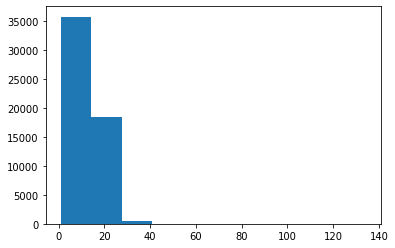

In [ ]:
len_titles = []
for i in range(len(int_titles)):
    len_titles.append(len(int_titles[i]))

plt.hist(len_titles)

##Preparation de X et Y 

Si je prends une longueur maximale de 30 ça devrait couvrir la plupart des titres qu'on a .On convertit maintenant en pytorch pour pouvoir les utiliser par la suite dans nos modèles.

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len = 20 
batch_size =  64 #128  # 
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

X = torch.zeros((len(int_titles),max_len)).long()

for i, text in enumerate(int_titles):
  lenght = min(max_len,len(text))
  X[i,:lenght] = torch.LongTensor(text[:lenght])

Y = torch.tensor(int_topics)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([54729, 20]) torch.Size([54729])
tensor([49, 50, 51, 52, 53, 54, 10, 36, 55,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0') tensor(4, device='cuda:0')


In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([38310, 20])
torch.Size([16419, 20])
torch.Size([38310])
torch.Size([16419])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(int_topics))
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        drop = self.dropout(hidden)
        return self.decision(drop.transpose(0, 1).contiguous().view(x.size(0), -1))

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(56473, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=54729, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5])

tensor([[ 0.0204,  0.2174,  0.2522,  ..., -0.0999, -0.5326, -0.1308],
        [ 0.0983,  0.4096,  0.0862,  ..., -0.1266, -0.6404, -0.0459],
        [ 0.1937,  0.1229, -0.0215,  ...,  0.0373, -0.3704, -0.3394],
        [ 0.5339,  0.3500,  0.2149,  ...,  0.0104, -0.6430, -0.1629],
        [ 0.4904,  0.6073,  0.5381,  ..., -0.0349, -0.1874,  0.1595]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_model,10)  #la loss diminue bien sur les données d'apprentissage,  l'accuracy est bien meilleur qu'avec bibliocovid  mais elle diminue 

0 0.02824035625300934 0.02066687184540637 0.5478409160119374
1 0.017842595132577826 0.016005435875122972 0.6671539070588952
2 0.013378098176870542 0.014481440492346906 0.6950484195139777
3 0.01058532672960246 0.014449288110087144 0.7060722333881478
4 0.008327845598956805 0.015278980581527636 0.7055849929959194
5 0.0063672011346208365 0.01639980377418506 0.703392411230891
6 0.004674522166804774 0.018884154920260285 0.6892015348072356
7 0.0034671772437676286 0.02007271307773266 0.6857908520616359
8 0.0025542494078796174 0.02202422404392344 0.6742188927462086
9 0.001993265248911907 0.02358116845612956 0.6860344722577502
10 0.0015175486530712848 0.02482574870303383 0.6852427066203788
11 0.0012076130725396687 0.02644925305828687 0.6828065046592362
12 0.0009528577711403514 0.0282138255149411 0.6820147390218649
13 0.0008192395415576187 0.02835641389236111 0.6866435227480359
14 0.0006575018160263452 0.029853103965896587 0.6819538339728364
15 0.0006057874822376003 0.0309946171853609 0.677203240

##Application du CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(int_topics))

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (embed): Embedding(56473, 128)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=54729, bias=True)
)

In [ ]:
cnn_model(X[:5])

tensor([[-0.3006,  0.5565, -0.3422,  ..., -0.0780, -0.4225, -0.1786],
        [-0.0476, -0.1542, -0.0431,  ...,  0.9210, -0.0243,  0.2301],
        [ 0.4740, -0.1070, -0.7012,  ...,  0.0280,  0.4205,  0.1787],
        [-0.4492,  0.3334, -0.0551,  ...,  0.7467,  0.4830, -0.4009],
        [-0.5925,  0.1189, -0.4350,  ...,  0.8281,  0.6401, -0.5185]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(cnn_model,10) #la loss diminue aussi et l'accuracy est déjà meilleur

0 0.014071281287353365 0.008828853067377974 0.6185516779341007
1 0.008585903677856974 0.00768031291080542 0.6731226018636945
2 0.0074302548420581704 0.007139244209697066 0.6914550216212924
3 0.006612380764186305 0.0067769978541434555 0.7061331384371764
4 0.005957760903580759 0.006604229048374575 0.7134417443206041
5 0.00531478408297183 0.0065627878545313515 0.7186186734880322
6 0.004731488194393446 0.006592096618949964 0.7231865521651745
7 0.004248823814776696 0.006737661874281938 0.7212375905962605
8 0.0037771962114364972 0.006920577997818332 0.7237346976064316
9 0.003339418721040339 0.007102636677011139 0.7242828430476886


Accuracy meilleur et loss diminue bien, on a de meilleurs résultats qu'avec bibliocovid 



##Application du RNN+CNN 

In [ ]:
class RNN_CNN(nn.Module): #But sortie du RNN en entrée du CNN  #je declare toutes mes couches
    def __init__(self): 
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)  # (batch,seq_len,hidden_size*num_directions) 
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(int_topics))

    def forward(self, x): #afficher la taille au fur et à mesure - utiliser des nombers premiers pour tester 
                        #je veux un tenseur de taille (batch,seq_len,hidden_size*num_directions)
        embed = self.embed(x)
        output,hidden = self.rnn(embed)
        conv = F.relu(self.conv(output.transpose(1,2))) #.transpose(1,2))) #la couche de convolution veut cette taille en entrée(batch_size, embedding_size, sequence_length)
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

rnn_cnn_model = RNN_CNN()
rnn_cnn_model.to(device)

RNN_CNN(
  (embed): Embedding(56473, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=54729, bias=True)
)

In [ ]:
rnn_cnn_model(X[:5])

tensor([[ 0.3342, -0.1345,  0.4043,  ..., -0.1295,  0.1037, -0.0341],
        [ 0.3303,  0.0126,  0.5974,  ..., -0.0367,  0.0921,  0.1855],
        [ 0.0730, -0.3015,  0.3963,  ...,  0.0753,  0.0658, -0.0059],
        [ 0.3534, -0.2003,  0.6646,  ..., -0.0948,  0.1461,  0.0805],
        [ 0.3323,  0.0443,  0.5377,  ..., -0.2152,  0.0271,  0.1444]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_cnn_model,10)

0 0.014499956878163241 0.00845211642662205 0.6343869906815275
1 0.007653101426881089 0.007186427455602156 0.6949875144649491
2 0.00620679124096796 0.00694908726352585 0.7067421889274621
3 0.005162401972287506 0.006960995479437137 0.7145989402521469
4 0.00422153101985556 0.00740925523626201 0.7140507948108898
5 0.003358302649311844 0.008044646616009355 0.7080821000060905
6 0.0025876743437469986 0.008880194879869093 0.7105183019672331
7 0.0019779408696763696 0.010240999835077248 0.7054022778488337
8 0.0015280556249259907 0.01167322970517 0.6956574700042634
9 0.0011749249231848206 0.012565108184598382 0.693464888239235


## Comparaison des résultats 

Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour les modèles choisis : RNN, CNN et RNN + CNN. Nous faisons varier le nombre de batch en maintenant le nombre d'epochs à 10. On note pour chaque modèle l'accuracy et la loss obtenue (**loss/accuracy**).

*A noter que lorsqu'on fait varier le batch_size on se limite à des epochs de 10*

Remarque : Augmenter le nombre d'epochs est très contraignant au niveau du temps d'exécution et n'apporte pas particulièrement d'amélioration notable (en tout cas sur le RNN) 

|Loss/Accuracy (en %) || RNN | CNN | RNN+CNN |
|----------||----------|----------|----------|
| batch_size **64**   || 0,2 / 69 | 0,49 / 71 | 0,1 / 68 |
| batch_size **128** || 0,2 / 69 | 0,3 / 72 | 0,1 / 69  |


# Contenu 6 : Abstract LitCovid  
Dans ce notebook nous allons tester trois modèles **RNN, CNN et RNN+CNN** pour prédire les **catégories** à partir des **abstracts** de l'article sur le dataset de **LitCovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances des modèles choisis en fonction de certains paramètres que nous avons choisi de faire varier. 

#Initialisation 

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


In [ ]:
# import os 
# os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

On récupère les fichiers json 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json

--2021-01-05 18:40:09--  https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104815092 (100M) [application/json]
Saving to: ‘data/litcovid.json’

litcovid.json       100%[===================>]  99.96M  19.7MB/s    in 6.2s    

2021-01-05 18:40:16 (16.2 MB/s) - ‘data/litcovid.json’ saved [104815092/104815092]

FINISHED --2021-01-05 18:40:16--
Total wall clock time: 7.1s
Downloaded: 1 files, 100M in 6.2s (16.2 MB/s)


In [ ]:
# bibliovid_file = open('./bibliovid.json')
litcovid_file = open('data/litcovid.json')

# data_bibliovid = json.loads(bibliovid_file.read())
data_litcovid = json.loads(litcovid_file.read())

# bibliovid_file.close()
litcovid_file.close()

In [ ]:
# print(data_bibliovid[0])
print(data_litcovid[0])

{'pmid': 33273934, 'pmcid': 'PMC7698443', 'title': 'Cardiac anesthesia and COVID-19 outbreak: What should we know?', 'journal': 'J Res Med Sci', 'authors': ['Ziyaeifard, Mohsen', 'Ziyaeifard, Parisa'], 'date': '2020-12-05T12:00:00Z', '_id': '33273934', 'topics': ['Prevention'], 'text_hl': None, 'abstract': 'The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidel

#Litcovid : prediction des catégories en fonction des abstracts

In [ ]:
print(data_litcovid[0]['abstract'])
print(data_litcovid[0]['topics'])
print(len(data_litcovid))

The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidelines to treat patients with COVID-19.
['Prevention']
77522


Je commence par récupérer que ceux qui ont topics en key 

In [ ]:
abstracts = []
labels = {}
miss_data = []

for i in range(len(data_litcovid)):
  if 'abstract' in data_litcovid[i] and 'topics' in data_litcovid[i] : 
    abstracts.append(data_litcovid[i]['abstract'])
    labels[i] = (len(data_litcovid[i]['topics']),data_litcovid[i]['topics'])
  else : 
    miss_data.append(data_litcovid[i]['_id'])


In [ ]:
print(len(abstracts))
print(len(miss_data)) #bcp de data qui manque (à voir si on peut raffiner le modèle pour les prendre en compte)

54687
22835


##Les topics 

Ce que je vais faire pour commencer c'est prendre pour chacun la première catégorie, après peut-être que je pourrais en prendre plus mais je ne sais pas encore comment gérer ça 

In [ ]:
list(labels.values())[0][1][0]

'Prevention'

In [ ]:
topic_tronque = [0]*len(labels)

for i in range(len(list(labels.values()))) :
  topic_tronque[i] = list(labels.values())[i][1][0] #je prends que le premier topic

In [ ]:
topic_vocab = {topic: i for i, topic in enumerate(set(topic_tronque))}
print(topic_vocab) #8 topics dont un none (à gérer pour la suite)

int_topics = [topic_vocab[topic] for topic in topic_tronque]
print(int_topics[:5])
print(len(topic_vocab))

{'Treatment': 0, 'Prevention': 1, 'Epidemic Forecasting': 2, 'Transmission': 3, 'General Info': 4, 'NONE': 5, 'Diagnosis': 6, 'Mechanism': 7, 'Case Report': 8}
[1, 6, 6, 0, 7]
9


##Abstract 

on  transforme les abstracts en entiers 

In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))

int_abstracts = []
for text in abstracts : 
    int_abstracts.append([vocab[token] for token in text.split()])

print(int_abstracts[10])
print(abstracts[10])

[753, 46, 754, 41, 755, 756, 197, 343, 183, 757, 758, 397, 46, 759, 760, 761, 13, 762, 46, 124, 2, 338, 339, 763, 86, 562, 764, 11, 4, 765, 766, 24, 3, 46, 767, 768, 89, 769, 770, 46, 731, 38, 771, 681, 26, 449, 86, 732, 772, 43, 773, 171, 704, 89, 774, 775, 41, 776, 3, 777, 57, 46, 778, 779, 13, 780, 781, 782, 41, 596, 778, 783, 632, 46, 784, 785, 140, 124, 786, 26, 787, 788, 24, 789, 111, 200, 790, 791, 46, 606, 792, 793, 794, 11, 773, 795, 171, 376, 46, 780, 796, 41, 395, 797, 779, 9, 89, 798, 799, 11, 784, 800, 0, 801, 425, 189, 781, 802, 136, 338, 803, 116, 804, 13, 805, 171, 136, 398, 806, 307, 277, 807, 808, 13, 809, 810, 811, 57, 660, 812, 26, 200, 43, 14, 23, 86, 254, 705, 136, 813, 46, 814, 13, 815, 432, 816, 0, 817, 818, 41, 46, 810, 819, 76, 46, 820, 821, 822, 3, 823, 520, 11, 824, 825, 826, 790, 827, 258, 828, 829, 76, 830, 100, 57, 831, 832, 833, 834, 835, 13, 182, 165, 836, 790, 172, 837, 60, 258, 63, 794, 57, 838, 839, 840, 136, 89, 841, 423, 13, 172, 842, 136, 843, 844

conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_abstracts[10]]) # c'est bon 

['Since', 'the', 'emergence', 'of', 'SARS-CoV-1', '(2002),', 'novel', 'coronaviruses', 'have', 'emerged', 'periodically', 'like', 'the', 'MERS-', 'CoV', '(2012)', 'and', 'now,', 'the', 'SARS-CoV-2', 'outbreak', 'which', 'has', 'posed', 'a', 'global', 'threat', 'to', 'public', 'health.', 'Although,', 'this', 'is', 'the', 'third', 'zoonotic', 'coronavirus', 'breakout', 'within', 'the', 'last', 'two', 'decades,', 'there', 'are', 'only', 'a', 'few', 'platforms', 'that', 'provide', 'information', 'about', 'coronavirus', 'genomes.', 'None', 'of', 'them', 'is', 'specific', 'for', 'the', 'virulence', 'glycoproteins', 'and', 'complete', 'sequence-structural', 'features', 'of', 'these', 'virulence', 'factors', 'across', 'the', 'betacoronavirus', 'family', 'including', 'SARS-CoV-2', 'strains', 'are', 'lacking.', 'Against', 'this', 'backdrop,', 'we', 'present', 'DBCOVP', '(http://covp.immt.res.in/),', 'the', 'first', 'manually-curated,', 'web-based', 'resource', 'to', 'provide', 'extensive', 'info

Pour décider de max_len plus tard il faut qu'on voit la longueur maximale d'abstract qu'on a 

(array([3.2684e+04, 2.0863e+04, 9.9800e+02, 8.0000e+01, 3.6000e+01,
        1.9000e+01, 5.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([   0. ,  187.2,  374.4,  561.6,  748.8,  936. , 1123.2, 1310.4,
        1497.6, 1684.8, 1872. ]),
 <a list of 10 Patch objects>)

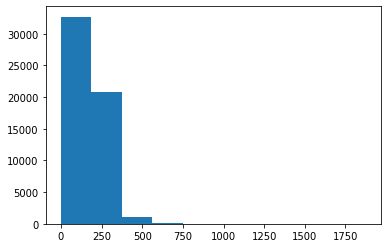

In [ ]:
len_abstracts = []
for i in range(len(int_abstracts)):
    len_abstracts.append(len(int_abstracts[i]))

plt.hist(len_abstracts)

On peut s'arreter à max_len = 300 

##Preparation de X et Y 

Si je prends une longueur maximale de 30 ça devrait couvrir la plupart des titres qu'on a .On convertit maintenant en pytorch pour pouvoir les utiliser par la suite dans nos modèles.

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len = 300 
num_features = 9 #9 catégories  
batch_size =  128 #64 #   
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

X = torch.zeros((len(int_abstracts),max_len)).long()

for i, text in enumerate(int_abstracts):
  lenght = min(max_len,len(text))
  X[i,:lenght] = torch.LongTensor(text[:lenght])

Y = torch.tensor(int_topics)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([54687, 300]) torch.Size([54687])
tensor([  0, 432, 433,  11,  17,  16,  18,  83,  89, 434, 435,   3,  86, 436,
        437, 136,  46, 438, 439,  41, 440, 338,  14, 441,   9, 442,  11,  86,
        443, 444, 445, 446, 447, 432, 433, 448, 449, 450,  46, 451,  41,  46,
        452,  11, 453,  46,  48, 454, 455,  14, 456, 457,  46, 396,  11, 458,
        459,  13, 460, 461,  86,  28,  11, 338,  46, 333, 179, 462, 463, 211,
        464, 465,  46, 458, 466,  43,  14, 467, 136,   1, 468, 469, 470, 471,
        472,   3, 473, 384,  86, 474,  15,  41, 475,  13, 476, 477, 277, 478,
         41,  46, 479, 480, 373, 481, 482,  24, 483, 111, 200,  46, 333, 484,
         41, 485,  13, 486, 487,  46, 488, 489,  43, 490,  46, 447, 432, 433,
        136,   1, 491, 492,  11, 493, 228, 494, 495,  11, 496, 497,  41, 498,
         14, 448, 449, 499, 432, 500, 136,   1, 468, 455, 456, 501,  46,  28,
         57, 502, 503, 485, 504,  46, 421, 505,  41,  46, 506, 136,   1,  13,
        219, 507, 1

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([38280, 300])
torch.Size([16407, 300])
torch.Size([38280])
torch.Size([16407])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        y_scores = model(x)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_scores = model(x)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 1 * 1, len(int_topics))
        
    def forward(self, x):
        embed = self.embed(x)
        output, hidden = self.rnn(embed)
        drop = self.dropout(hidden)
        return self.decision(drop.transpose(0, 1).contiguous().view(x.size(0), -1))

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(257916, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=54687, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5])

tensor([[ 0.3197, -0.1098, -0.4024,  ..., -0.4020,  0.3635,  0.0883],
        [ 0.0748,  0.0320, -0.7510,  ..., -0.5970,  0.1879, -0.1300],
        [ 0.2801, -0.1704, -0.6624,  ..., -0.4331, -0.0108,  0.2160],
        [ 0.1676,  0.1119, -0.3194,  ..., -0.8362,  0.3501,  0.1458],
        [ 0.4216, -0.0876, -0.3985,  ..., -0.4379, -0.1843,  0.1105]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
%time fit(rnn_model,10)  #la loss diminue bien sur les données d'apprentissage,  l'accuracy est bien meilleur qu'avec bibliocovid  mais elle diminue 

0 0.016827027965239723 0.01220211081337128 0.41829706832449565
1 0.011881294890132692 0.010692454419043337 0.5651855915158164
2 0.009767668785346338 0.009172170843874332 0.6259523374169562
3 0.008197543392485336 0.007988605158067588 0.6656914731517035
4 0.007051954820923421 0.007232419604712229 0.6970195648198939
5 0.006252886121946629 0.007203230203494966 0.7022612299628207
6 0.0056730247189289845 0.007407263612488531 0.6936673371122082
7 0.005210224036205182 0.007711040895193145 0.678612787224965
8 0.004748756422728394 0.007974803182523226 0.6831230572316694
9 0.004435757736460371 0.009309034944198217 0.6637410861217773
CPU times: user 1min 11s, sys: 22.4 s, total: 1min 33s
Wall time: 1min 34s


##Application du CNN 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(int_topics))

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN()
cnn_model.to(device)

CNN(
  (embed): Embedding(257916, 128)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=54687, bias=True)
)

In [ ]:
cnn_model(X[:5])

tensor([[-0.8063, -0.7779, -0.7059,  ...,  0.9885, -0.2217, -0.4677],
        [-1.4830, -0.2610, -0.1206,  ...,  0.6092, -0.3147, -0.3476],
        [-0.7161,  0.6225,  0.0898,  ..., -0.0616, -0.2766,  0.4086],
        [-1.5915,  0.4333, -0.3410,  ...,  0.5903,  0.0192,  0.3273],
        [-1.3100, -0.0269, -0.5041,  ..., -1.6624,  0.2956, -0.6093]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(cnn_model,10) #la loss diminue aussi et l'accuracy est déjà meilleur

0 0.014425914112552455 0.008264577896639903 0.6534406046199793
1 0.008674295682580742 0.00757567299606087 0.673614920460779
2 0.008023978561131807 0.007253815328979678 0.6875723776436886
3 0.007689042957723452 0.007099530269932964 0.6931187907600415
4 0.007391338269133802 0.006960960609237012 0.6971414640092644
5 0.007153972259322678 0.006932370404173544 0.697994758334857
6 0.006948203814985734 0.006777390182842943 0.7062229536173584
7 0.006678168210342075 0.006695616410202479 0.7096361309197294
8 0.0064153783288059315 0.0066873402215375565 0.7096970805144146
9 0.006205900808720379 0.006618565114984392 0.7114646187602852


Accuracy meilleur et loss diminue bien, on a de meilleurs résultats qu'avec bibliocovid 



##Application du RNN+CNN 

In [ ]:
class RNN_CNN(nn.Module): #But sortie du RNN en entrée du CNN  #je declare toutes mes couches
    def __init__(self): 
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)  # (batch,seq_len,hidden_size*num_directions) 
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(int_topics))

    def forward(self, x): #afficher la taille au fur et à mesure - utiliser des nombers premiers pour tester 
                        #je veux un tenseur de taille (batch,seq_len,hidden_size*num_directions)
        embed = self.embed(x)
        output,hidden = self.rnn(embed)
        conv = F.relu(self.conv(output.transpose(1,2))) #.transpose(1,2))) #la couche de convolution veut cette taille en entrée(batch_size, embedding_size, sequence_length)
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

rnn_cnn_model = RNN_CNN()
rnn_cnn_model.to(device)

RNN_CNN(
  (embed): Embedding(257916, 128)
  (rnn): GRU(128, 128, batch_first=True)
  (conv): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dropout): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=128, out_features=54687, bias=True)
)

In [ ]:
rnn_cnn_model(X[:5])

tensor([[ 0.0817, -0.1623,  0.3183,  ..., -0.4582,  0.0708, -0.1743],
        [ 0.1906,  0.3327,  0.1194,  ..., -0.3668,  0.5344, -0.0312],
        [ 0.0264, -0.1295,  0.3470,  ..., -0.4918,  0.3662, -0.2014],
        [ 0.0543, -0.2793,  0.4762,  ..., -0.5505,  0.2516, -0.2320],
        [ 0.2151,  0.3184,  0.0162,  ..., -0.4662,  0.2322,  0.1602]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_cnn_model,10)

0 0.014816094069209343 0.008495232421286532 0.6415554336563661
1 0.008129040772326937 0.007488523841361979 0.6807460230389468
2 0.007134954376358348 0.007028139548668763 0.7016517340159688
3 0.006483796428375203 0.007037167271000089 0.7065886511854697
4 0.00588035582834339 0.0071481502622124365 0.7046992137502286
5 0.0053554523413633015 0.008027161894038164 0.6840373011519474
6 0.004932733289393827 0.008230965454414048 0.6857438898031328
7 0.004539527516381946 0.00881742963903077 0.6873895288596331
8 0.004292848255017446 0.009362042004719014 0.6873285792649478
9 0.00405223454653801 0.009943618608464152 0.6933016395440971


## Comparaison des résultats 

Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour les modèles choisis : RNN, CNN et RNN + CNN. Nous faisons varier le nombre de batch en maintenant le nombre d'epochs à 10. On note pour chaque modèle l'accuracy et la loss obtenue (**loss/accuracy**).

*A noter que lorsqu'on fait varier le batch_size on se limite à des epochs de 10*

Remarque : 
1) Augmenter le nombre d'epochs est très contraignant au niveau du temps d'exécution et n'apporte pas particulièrement d'amélioration notable surtout qu'on a déjà du surapprentissage sur les 10 premiers epochs.

2) Augmenter le nombre de batchs n'a pas forcément une bonne répercussion sur la performance de nos modèles notamment pour le RNN , pour les deux autres modèles les performances sont légèrement améliorées. 



|Loss/Accuracy (en %) || RNN | CNN | RNN+CNN |
|----------||----------|----------|----------|
| batch_size **64**   || 0,7 / 67 | 1 / 70 | 0,7 / 68 |
| batch_size **128** || 0,4 / 66 | 0,6 / 71 | 0,4 / 69  |


# Contenu 7 : Titre + Abstract LitCovid  
Dans ce notebook nous allons tester un modèle qui prend en compte **les titres et les abstracts** à la fois pour prédire les **catégories** sur le dataset de **LitCovid**. A la fin du notebook, vous pourrez trouver un **tableau récapitulatif** qui compare les performances du modèle RNN pour les titres seuls, les abstracts seuls puis les deux réunis. 

#Initialisation 

In [ ]:
# from google.colab import drive
# drive.mount('drive')

Mounted at drive


In [ ]:
# import os 
# os.chdir('drive/My Drive/Colab Notebooks/PSTALN')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json 

#Import des données 

On récupère les fichiers json 

In [ ]:
!wget -r --no-parent -nd -e robots=off -P data/ -A .json https://pageperso.lis-lab.fr/benoit.favre/covid19-data/20201206/litcovid.json

In [ ]:
# bibliovid_file = open('./bibliovid.json')
litcovid_file = open('data/litcovid.json')

# data_bibliovid = json.loads(bibliovid_file.read())
data_litcovid = json.loads(litcovid_file.read())

# bibliovid_file.close()
litcovid_file.close()

In [ ]:
# print(data_bibliovid[0])
print(data_litcovid[0])

{'pmid': 33273934, 'pmcid': 'PMC7698443', 'title': 'Cardiac anesthesia and COVID-19 outbreak: What should we know?', 'journal': 'J Res Med Sci', 'authors': ['Ziyaeifard, Mohsen', 'Ziyaeifard, Parisa'], 'date': '2020-12-05T12:00:00Z', '_id': '33273934', 'topics': ['Prevention'], 'text_hl': None, 'abstract': 'The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidel

#Litcovid : prediction des catégories en fonction des abstracts, cette fois je prends toutes les catégories 

In [ ]:
print(data_litcovid[0]['abstract'])
print(data_litcovid[0]['topics'])
print(len(data_litcovid))

The COVID-19 outbreak is public health emergency, spreads easily from human to human, and may cause acute severe respiratory syndrome. The anesthesia teams who perform this procedure are at risk aerosolization and need special consideration and safety measures. Cardiac anesthesiologist follows two aims, recognition of COVID-19 patients that need surgery and decreasing the risk of perioperative viral transmission to coworkers. An isolated operating room (negative pressure operating room for COVID-19) should be available. It is important to regulate workflow and practices, anesthesia management, healthcare, and staff. Cardiac anesthesiologist and health-care workers must be use guidelines to treat patients with COVID-19.
['Prevention']
77522


Je commence par récupérer que ceux qui ont topics en key 

In [ ]:
abstracts = []
titles = []
labels = {}
miss_data = []

for i in range(len(data_litcovid)):
  if 'abstract' in data_litcovid[i] and 'topics' in data_litcovid[i] and 'title' in data_litcovid[i] : 
    titles.append(data_litcovid[i]['title'])
    abstracts.append(data_litcovid[i]['abstract'])
    labels[i] = (len(data_litcovid[i]['topics']),data_litcovid[i]['topics'])
  else : 
    miss_data.append(data_litcovid[i]['_id'])


In [ ]:
print(len(abstracts))
print(len(titles))
print(len(miss_data)) #bcp de data qui manque (à voir si on peut raffiner le modèle pour les prendre en compte)

54687
54687
22835


##Les topics 

In [ ]:
topics = []

for i in range(len(list(labels.values()))):
  topics.append(list(labels.values())[i][1])

In [ ]:
topics[0:10]

[['Prevention'],
 ['Diagnosis', 'Mechanism', 'Treatment'],
 ['Diagnosis', 'Treatment'],
 ['Treatment'],
 ['Mechanism'],
 ['Mechanism', 'Treatment'],
 ['Treatment'],
 ['Prevention'],
 ['Prevention'],
 ['Prevention', 'Transmission']]

In [ ]:
len_topic_list = []
for topic_list in topics : 
  len_topic_list.append(len(topic_list))

print(max(len_topic_list))


5


###One-hot encoding pour prendre toutes les catégories

In [ ]:
import collections 
topic_vocab = collections.defaultdict(lambda: len(topic_vocab))

int_topics = np.zeros((len(topics),5))
for i,topic_list in enumerate(topics) : 
  for j,topic in enumerate(topic_list) : 
    for token in topic.split():
      int_topics[i, j] = topic_vocab[token] +1

print(int_topics[0:10]) #int_topics est one-hot encodé la ou il ya 1 correspond la catégorie 
print(topics[0:10])

[[1. 0. 0. 0. 0.]
 [2. 3. 4. 0. 0.]
 [2. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0.]
 [3. 4. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 5. 0. 0. 0.]]
[['Prevention'], ['Diagnosis', 'Mechanism', 'Treatment'], ['Diagnosis', 'Treatment'], ['Treatment'], ['Mechanism'], ['Mechanism', 'Treatment'], ['Treatment'], ['Prevention'], ['Prevention'], ['Prevention', 'Transmission']]


In [ ]:
#on  process int_topics sous forme de one hot encoding 
for i in range(len(int_topics)): 
  for j in range(int_topics.shape[1]): 
    if int_topics[i,j] != 0 : 
      int_topics[i,j] = 1 

print(int_topics[0:10])


[[1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]]


### On tronque la liste des topics 

In [ ]:
topic_tronque = [0]*len(labels)

for i in range(len(list(labels.values()))) :
  if list(labels.values())[i][1][0] != 'NONE' : 
    topic_tronque[i] = list(labels.values())[i][1][0] #je prends que le premier topic sauf si c'est None

In [ ]:
topic_vocab = {topic: i for i, topic in enumerate(set(topic_tronque))}
print(topic_vocab) #8 topics 

int_topics = [topic_vocab[topic] for topic in topic_tronque]
print(int_topics[:5])

{0: 0, 'General Info': 1, 'Case Report': 2, 'Mechanism': 3, 'Prevention': 4, 'Treatment': 5, 'Diagnosis': 6, 'Epidemic Forecasting': 7, 'Transmission': 8}
[4, 6, 6, 5, 3]


##Abstract & Title  

on  transforme les abstracts et les titres en entiers 

In [ ]:
import collections 
vocab = collections.defaultdict(lambda: len(vocab))

int_abstracts = []
for text in abstracts : 
    int_abstracts.append([vocab[token] for token in text.split()])

int_titles = []
for text in titles : 
    int_titles.append([vocab[token] for token in text.split()])

print(int_abstracts[10])
print(abstracts[10])

print(int_titles[10])
print(titles[10])
#on vérifie que le vocab s'est bien partagé dans abstracts et title : pour of c'est bien codé en 41 dans les deux 

[753, 46, 754, 41, 755, 756, 197, 343, 183, 757, 758, 397, 46, 759, 760, 761, 13, 762, 46, 124, 2, 338, 339, 763, 86, 562, 764, 11, 4, 765, 766, 24, 3, 46, 767, 768, 89, 769, 770, 46, 731, 38, 771, 681, 26, 449, 86, 732, 772, 43, 773, 171, 704, 89, 774, 775, 41, 776, 3, 777, 57, 46, 778, 779, 13, 780, 781, 782, 41, 596, 778, 783, 632, 46, 784, 785, 140, 124, 786, 26, 787, 788, 24, 789, 111, 200, 790, 791, 46, 606, 792, 793, 794, 11, 773, 795, 171, 376, 46, 780, 796, 41, 395, 797, 779, 9, 89, 798, 799, 11, 784, 800, 0, 801, 425, 189, 781, 802, 136, 338, 803, 116, 804, 13, 805, 171, 136, 398, 806, 307, 277, 807, 808, 13, 809, 810, 811, 57, 660, 812, 26, 200, 43, 14, 23, 86, 254, 705, 136, 813, 46, 814, 13, 815, 432, 816, 0, 817, 818, 41, 46, 810, 819, 76, 46, 820, 821, 822, 3, 823, 520, 11, 824, 825, 826, 790, 827, 258, 828, 829, 76, 830, 100, 57, 831, 832, 833, 834, 835, 13, 182, 165, 836, 790, 172, 837, 60, 258, 63, 794, 57, 838, 839, 840, 136, 89, 841, 423, 13, 172, 842, 136, 843, 844

conversion dans l'autre sens 

In [ ]:
rev_vocab = {y: x for x,y in vocab.items()}
print([rev_vocab[word_id] for word_id in int_abstracts[10]])  
print([rev_vocab[word_id] for word_id in int_titles[10]]) # c'est bon

['Since', 'the', 'emergence', 'of', 'SARS-CoV-1', '(2002),', 'novel', 'coronaviruses', 'have', 'emerged', 'periodically', 'like', 'the', 'MERS-', 'CoV', '(2012)', 'and', 'now,', 'the', 'SARS-CoV-2', 'outbreak', 'which', 'has', 'posed', 'a', 'global', 'threat', 'to', 'public', 'health.', 'Although,', 'this', 'is', 'the', 'third', 'zoonotic', 'coronavirus', 'breakout', 'within', 'the', 'last', 'two', 'decades,', 'there', 'are', 'only', 'a', 'few', 'platforms', 'that', 'provide', 'information', 'about', 'coronavirus', 'genomes.', 'None', 'of', 'them', 'is', 'specific', 'for', 'the', 'virulence', 'glycoproteins', 'and', 'complete', 'sequence-structural', 'features', 'of', 'these', 'virulence', 'factors', 'across', 'the', 'betacoronavirus', 'family', 'including', 'SARS-CoV-2', 'strains', 'are', 'lacking.', 'Against', 'this', 'backdrop,', 'we', 'present', 'DBCOVP', '(http://covp.immt.res.in/),', 'the', 'first', 'manually-curated,', 'web-based', 'resource', 'to', 'provide', 'extensive', 'info

Pour décider de max_len plus tard il faut qu'on voit la longueur maximale d'abstract qu'on a 

(array([3.5730e+04, 1.8407e+04, 5.1800e+02, 2.4000e+01, 3.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  14.3,  27.6,  40.9,  54.2,  67.5,  80.8,  94.1, 107.4,
        120.7, 134. ]),
 <a list of 10 Patch objects>)

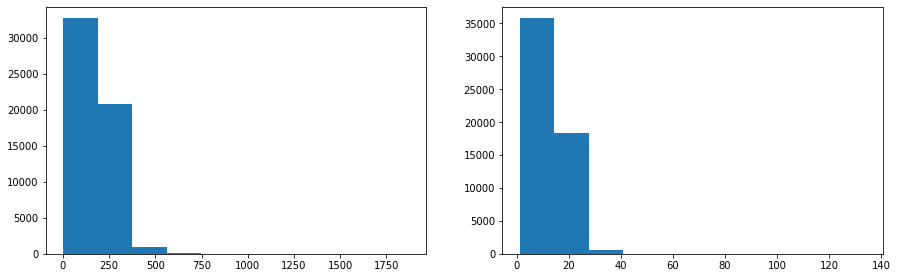

In [ ]:
len_abstracts = []
for i in range(len(int_abstracts)):
    len_abstracts.append(len(int_abstracts[i]))

len_titles = []
for i in range(len(int_titles)):
    len_titles.append(len(int_titles[i]))

fig = plt.figure(figsize=(15,10))
plt.subplot(2,2,1)  
plt.hist(len_abstracts)

plt.subplot(2,2,2) 
plt.hist(len_titles)

On peut s'arreter à max_len_abstract = 300 pour les abstracts et on va prendre max_len_title = 30 pour les titres 

##Preparation de X et Y 

Si je prends une longueur maximale de 30 ça devrait couvrir la plupart des titres qu'on a .On convertit maintenant en pytorch pour pouvoir les utiliser par la suite dans nos modèles.

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

max_len_abstract = 300 
max_len_title = 30
max_len = max_len_abstract + max_len_title
num_features = 5 
batch_size = 64 # 128   
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

X_abstract = torch.zeros((len(int_abstracts),max_len_abstract)).long()
X_title = torch.zeros((len(int_titles),max_len_title)).long()

for i, text in enumerate(int_abstracts):
  lenght = min(max_len_abstract,len(text))
  X_abstract[i,:lenght] = torch.LongTensor(text[:lenght])

for i, text in enumerate(int_titles):
  lenght = min(max_len_title,len(text))
  X_title[i,:lenght] = torch.LongTensor(text[:lenght])


X = torch.cat((X_abstract,X_title),-1)
Y = torch.tensor(int_topics)

X = X.to(device)
Y = Y.to(device)

print(X.size(),Y.size())
print(X[5],Y[5])


torch.Size([54687, 330]) torch.Size([54687])
tensor([     0,    432,    433,     11,     17,     16,     18,     83,     89,
           434,    435,      3,     86,    436,    437,    136,     46,    438,
           439,     41,    440,    338,     14,    441,      9,    442,     11,
            86,    443,    444,    445,    446,    447,    432,    433,    448,
           449,    450,     46,    451,     41,     46,    452,     11,    453,
            46,     48,    454,    455,     14,    456,    457,     46,    396,
            11,    458,    459,     13,    460,    461,     86,     28,     11,
           338,     46,    333,    179,    462,    463,    211,    464,    465,
            46,    458,    466,     43,     14,    467,    136,      1,    468,
           469,    470,    471,    472,      3,    473,    384,     86,    474,
            15,     41,    475,     13,    476,    477,    277,    478,     41,
            46,    479,    480,    373,    481,    482,     24,    483,    

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size())
print(X_test.size())
print(Y_train.size())
print(Y_test.size())

torch.Size([38280, 330])
torch.Size([16407, 330])
torch.Size([38280])
torch.Size([16407])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

In [ ]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #on modifie la fonction de loss également 
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        x_abstract = x[:,:max_len_abstract]
        x_title = x[:,max_len_abstract:]
        y_scores = model(x_abstract,x_title)
        loss = criterion(y_scores, y)
        # y_pred = y_scores > 0.5 
        y_pred = torch.max(y_scores,1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs): #train_loader, test_loader,
    criterion = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss() #on modifie la fonction de loss également 
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x_abstract = x[:,:max_len_abstract]
            x_title = x[:,max_len_abstract:]
            y_scores = model(x_abstract,x_title)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

##Application du modele RNN 

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.rnn_abstract = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.rnn_title = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        self.dropout_abstract = nn.Dropout(0.3)
        self.dropout_title = nn.Dropout(0.3)
        self.decision = nn.Linear(hidden_size * 2 , len(int_topics)) #on a deux couches
        
    def forward(self,x_abstract,x_title):
        embed_abstract = self.embed(x_abstract)
        embed_title = self.embed(x_title)
        output_abstract, hidden_abstract = self.rnn_abstract(embed_abstract)
        output_title, hidden_title = self.rnn_title(embed_title)
        drop_abstract = self.dropout_abstract(hidden_abstract).squeeze(0)
        drop_title = self.dropout_title(hidden_title).squeeze(0)
        cat = torch.cat((drop_abstract,drop_title),-1)
        return self.decision(cat.contiguous())

rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(280774, 128)
  (rnn_abstract): GRU(128, 128, batch_first=True)
  (rnn_title): GRU(128, 128, batch_first=True)
  (dropout_abstract): Dropout(p=0.3, inplace=False)
  (dropout_title): Dropout(p=0.3, inplace=False)
  (decision): Linear(in_features=256, out_features=54687, bias=True)
)

essayons sur les 5 premiers éléments 

In [ ]:
rnn_model(X[:5,:max_len_abstract],X[:5,max_len_abstract:])

tensor([[ 0.0268, -0.4224, -0.2745,  ...,  0.1250, -0.4301, -0.1411],
        [ 0.3960,  0.0733, -0.0101,  ...,  0.2639, -0.5866, -0.2939],
        [ 0.0794, -0.2121, -0.2935,  ...,  0.2015, -0.4821, -0.0286],
        [ 0.0522, -0.1325, -0.4074,  ...,  0.1809, -0.5901, -0.0214],
        [ 0.1784, -0.3219, -0.2442,  ..., -0.1208, -0.4871, -0.1048]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fit(rnn_model,10)  #la loss diminue bien sur les données d'apprentissage, par contre l'accuracy pas fameux 

0 0.025063910417048536 0.017793527979544737 0.6014506003535076
1 0.015121794201612722 0.012877651264181141 0.7302980435180106
2 0.01036568796388657 0.011631582353947302 0.7595538489669044
3 0.0073744584779987885 0.012134360278583485 0.758822453830682
4 0.005034359930669003 0.013929379293700202 0.7429755592125312
5 0.003331612691364972 0.015268957554229603 0.7464496861095874
6 0.0021776788680918334 0.01719741613815346 0.7498628634119583
7 0.0014829364972010978 0.018760750227903925 0.7459620893521058
8 0.0010633279225431857 0.019972229689430507 0.7440726519168648
9 0.0007404598326887206 0.02259157839695918 0.7332845736575851


## Comparaison des résultats avec title et abstract 


Nous allons récapituler nos résultats sous forme d'un tableau pour visualiser les résultats pour le RNN selon qu'on ait prédit les catégories à partir des titres, des abstracts puis des deux. (**loss/accuracy**).

On fixe le **batch_size = 64** et le **nombre d'epochs = 10** 

(*) Remarque : On a des performances assez similaire entre titre et abstract (contrairement à bibliocovid)

(**) Remarque :La meilleure performance est obtenue lorsqu'on prend les titres et les abstracts conjointement pareil qu'avec bibliocovid ==> le modèle a beaucoup plus de matière sur laquelle apprendre d'autant plus que le titre et l'abstract sont reliés et partagent le même vocabulaire. On atteint 73 % d'accuracy. 

(***) Remarque : Nos résultats sont assez satisfaisants mais restent encore à améliorer : 
- au niveau des topics, nous avons choisi de les tronquer et de ne prendre que la première catégorie au lieu de prendre toutes les catégories (à voir si le fait de prendre toutes les catégories ne feraient pas chuter nos performances) ; 
- notre dataset peut être amélioré si on gère mieux les datas qui manquent ;




|RNN || Title | Abstract | Title + Abstract |
|----------||----------|----------|----------|
| Loss (en %) || 0,2  | 0,7 | 0,07 |
| Accuracy (en %) || 69 | 67 |  73 |
